# Analyzing Sentiments and Topics in Taylor Swift's Lyrics

This project embarks on a comprehensive text mining and topic modeling journey to unravel the underlying sentiments and themes in the song lyrics of Taylor Swift. Taylor Swift, a renowned singer-songwriter, has captured hearts worldwide with her evocative lyrics, often reflecting personal experiences and universal emotions. Through advanced natural language processing techniques, this study aims to dissect her lyrics across various albums, extracting key themes and sentiment trends. The project leverages tools like NLTK for preprocessing, Gensim for topic modeling, and BERTopic for advanced theme extraction, offering insights into the emotional landscape and thematic richness of Swift's discography.

# 1. Data overview
This project utilizes a dataset sourced from Kaggle: https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums?select=07-lover.csv

This dataset is specifically tailored to explore the lyrical content of two prominent albums by Taylor Swift: "1989 Deluxe" and "Lover." The dataset offers a comprehensive collection of lyrics, presenting a unique opportunity to delve into the thematic and emotional nuances of Swift's songwriting.

Each entry in the dataset corresponds to a song, featuring key components such as the song's title, album name, and the complete lyrical text. This rich compilation of words and expressions forms the basis for a detailed textual analysis, allowing for a deeper understanding of the recurring themes, stylistic elements, and sentiment structures that define Taylor Swift's musical narrative.

The "1989 Deluxe" album, known for its vibrant and catchy tunes, reflects a significant phase in Swift's career, marking her transition into pop music. On the other hand, the "Lover" album encapsulates a spectrum of emotions and experiences, showcasing her evolution as an artist and a storyteller. Together, these albums provide a diverse and insightful representation of Swift's artistic
journey, making them ideal subjects for exploring her lyrical themes and sentiments through computational analysis.

In [1]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import re
import seaborn as sns
import statistics
import time
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from collections import defaultdict 
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from collections import Counter
from PIL import Image
import os
import wordcloud
from wordcloud import WordCloud



## Data preparation

In [2]:
# album1 = pd.read_csv('05-1989_deluxe.csv')
# album2 = pd.read_csv('07-lover.csv')
album1 = pd.read_csv('Data//05-1989_deluxe.csv')
album2 = pd.read_csv('Data//07-lover.csv')

In [3]:
merged_album1 = album1.groupby('track_n').agg({'track_title': 'first', 'album_name': 'first', 'lyric': ' '.join}).reset_index()
merged_album2 = album2.groupby('track_n').agg({'track_title': 'first', 'album_name': 'first', 'lyric': ' '.join}).reset_index()

albums = pd.concat([merged_album1, merged_album2]).reset_index(drop=True)

In [4]:
albums.head()

,track_n,track_title,album_name,lyric
0,1,Welcome to New York,1989 (Deluxe),"Walking through a crowd, the village is aglow ..."
1,2,Blank Space,1989 (Deluxe),"Nice to meet you, where you been? I could show..."
2,3,Style,1989 (Deluxe),"Midnight You come and pick me up, no headlight..."
3,4,Out of the Woods,1989 (Deluxe),Looking at it now It all seems so simple We we...
4,5,All You Had to Do Was Stay,1989 (Deluxe),"(Hey, hey, hey) (Hey, hey, hey) (Hey, hey, hey..."


In [5]:
#removing newline symbols, i.e. \n
albums['lyric'] = albums['lyric'].map(lambda x: re.sub('\n', ' ', x))

#removing all numbers
albums['lyric'] = albums['lyric'].map(lambda x: re.sub(r'[0-9]+', '', x))

#removing special signs as ,\!?/:;''()``’“-”—#
albums['lyric'] = albums['lyric'].map(lambda x: re.sub("[,\!?/:;''()``’“-”—#]", '', x))

#removing .
albums['lyric'] = albums['lyric'].map(lambda x: re.sub(r"([.]+)", '', x))

#all letters to lover case
albums['lyric'] = albums['lyric'].map(lambda x: x.lower())

#removing one-letter words
albums['lyric'] = albums['lyric'].map(lambda x: re.sub(r'\b\w\b', '', x))
   
albums['lyric'].head()

0    walking through  crowd the village is aglow ka...
1    nice to meet you where you been  could show yo...
2    midnight you come and pick me up no headlights...
3    looking at it now it all seems so simple we we...
4    hey hey hey hey hey hey hey hey hey hey hey he...
Name: lyric, dtype: object

In [6]:
def custom_tokenize(text):
    if not text:
        print('The text to be tokenized is a None type or empty. Defaulting to blank string.')
        return []
    return word_tokenize(text)

# Apply tokenization to the lyric column
albums['lyric'] = albums['lyric'].apply(custom_tokenize)

In [7]:
# Initialize a defaultdict to store frequency counts
FreqDict = defaultdict(int)

# Iterate over the tokenized lyrics in the DataFrame
for tList in albums['lyric']:
    # Use set to find unique tokens instead of converting to list after np.unique
    unique_tokens = set(tList)
    for token in unique_tokens:
        FreqDict[token] += 1

print('There are', len(FreqDict), 'unique tokens')


There are 1443 unique tokens


The analysis of the lyrics from Taylor Swift's album "1989 (Deluxe)" reveals a total of 1443 unique tokens. This indicates a diverse range of vocabulary used throughout the songs in this album.

In [8]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize the lyrics
def lemmatize_album_lyrics(albums_lyrics):
    return [[lemmatizer.lemmatize(word) for word in lyrics] for lyrics in albums_lyrics]

# Apply the lemmatization to the 'lyric' column of the albums dataframe
albums['lyric'] = lemmatize_album_lyrics(albums['lyric'])


In [9]:
# Initial list of stopwords
stop_words = nltk.corpus.stopwords.words('english')
additional_stop_words = ['oh', 'oh-oh', 'ooh', 'are', 'eh', 'ah', 'hey hey', 'hey hey hey', 'shakeshake', 'shakeshakeshake'
                         'daylightdaylight', 'wishwouldwish', 'welcomenew', 'welcomenewyork', 'wishwould', 'wouldwish']
stop_words.extend(additional_stop_words)

# Function to clean each stop word
def clean_stop_word(word):
    word = word.replace('\n', '')  # Remove newlines
    word = re.sub(r"[,\!?/:;''()``]", '', word)  # Remove specified punctuation
    word = re.sub(r"([.]+)", '', word)  # Remove periods
    return word

# Clean the stopwords
stop_words = [clean_stop_word(word) for word in stop_words]

# Display the first few stopwords
stop_words


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'youre',
 'youve',
 'youll',
 'youd',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'shes',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'thatll',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'fe

In [10]:
# lemmatization of stopwords
lemmatized_stop_words = set([lemmatizer.lemmatize(word) for word in stop_words])

# Function to remove stopwords from a song's lyrics
def remove_stopwords_from_lyrics(lyrics):
    return [word for word in lyrics if word not in lemmatized_stop_words]

# Apply the function to each song in the albums lyrics
albums_lyrics_cleaned = [remove_stopwords_from_lyrics(song) for song in albums['lyric']]


In [11]:
# Remove repetitive phrases before joining the lyrics
def remove_repetitive_phrases(lyrics_list):
    cleaned_lyrics = []
    for lyrics in lyrics_list:
        lyrics = ' '.join(lyrics)  # Join the words into a string
        lyrics = re.sub(r'\b(love love|love love love)\b', 'love', lyrics)
        cleaned_lyrics.append(lyrics.split())  # Split back into a list of words
    return cleaned_lyrics

# Apply the function
albums_lyrics_cleaned = remove_repetitive_phrases(albums_lyrics_cleaned)
albums_lyrics_cleaned


[['walking',
  'crowd',
  'village',
  'aglow',
  'kaleidoscope',
  'loud',
  'heartbeat',
  'coat',
  'everybody',
  'wanted',
  'something',
  'searching',
  'sound',
  'heard',
  'said',
  'welcome',
  'new',
  'york',
  'waiting',
  'welcome',
  'new',
  'york',
  'welcome',
  'new',
  'york',
  'welcome',
  'new',
  'york',
  'waiting',
  'welcome',
  'new',
  'york',
  'welcome',
  'new',
  'york',
  'new',
  'soundtrack',
  'could',
  'dance',
  'beat',
  'beat',
  'forevermore',
  'light',
  'bright',
  'never',
  'blind',
  'welcome',
  'new',
  'york',
  'waiting',
  'welcome',
  'new',
  'york',
  'welcome',
  'new',
  'york',
  'first',
  'dropped',
  'bag',
  'apartment',
  'floor',
  'took',
  'broken',
  'heart',
  'put',
  'drawer',
  'everybody',
  'someone',
  'else',
  'want',
  'want',
  'boy',
  'boy',
  'girl',
  'girl',
  'welcome',
  'new',
  'york',
  'waiting',
  'welcome',
  'new',
  'york',
  'welcome',
  'new',
  'york',
  'welcome',
  'new',
  'york',
  'w

## EDA

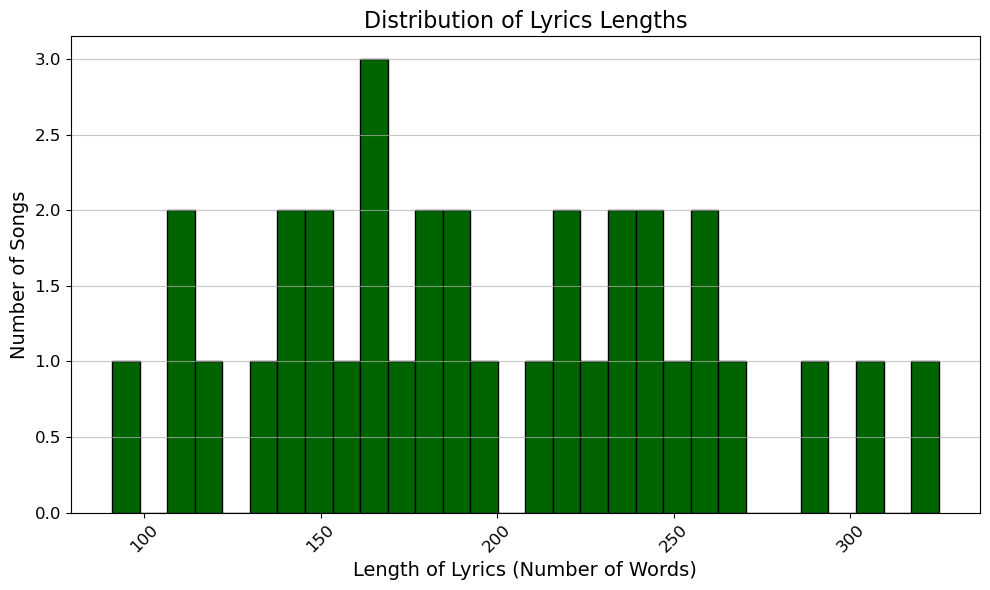

In [12]:
lyrics_lengths = [len(lyrics) for lyrics in albums_lyrics_cleaned]

plt.figure(figsize=(10, 6))
plt.hist(lyrics_lengths, bins=30, color='darkgreen', edgecolor='black')
plt.xlabel('Length of Lyrics (Number of Words)', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.title('Distribution of Lyrics Lengths', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)  # Adding a grid for the y-axis
plt.tight_layout()  # Adjusting the plot layout
plt.show()

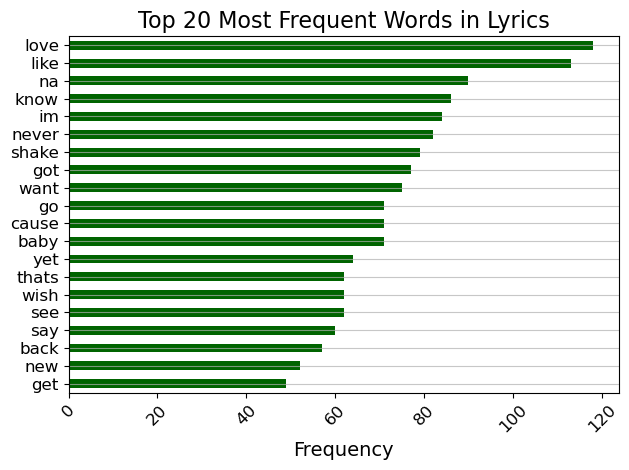

In [13]:
all_words = ' '.join([' '.join(lyrics) for lyrics in albums_lyrics_cleaned]).lower().split()

# Filter for long words (longer than 7 characters)
long_words = [word for word in all_words]

# Count the frequency of each long word
long_word_freq = pd.Series(long_words).value_counts()

# Plot the top 20 most frequent long words
long_word_freq[:20][::-1].plot(kind='barh', color='darkgreen')
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 20 Most Frequent Words in Lyrics', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)  # Adding a grid for the y-axis
plt.tight_layout()  # Adjusting the plot layout
plt.show()

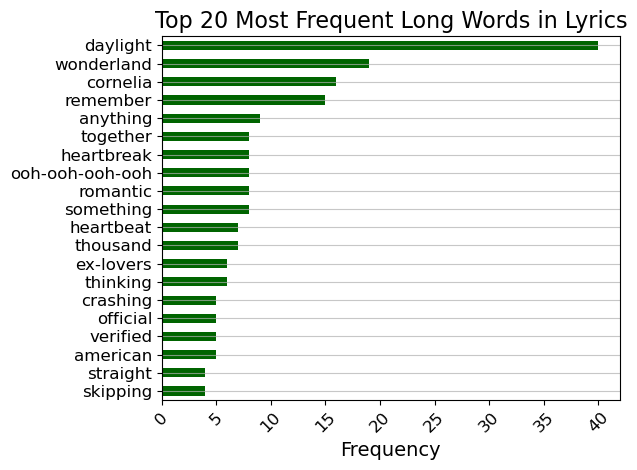

In [14]:
all_words = ' '.join([' '.join(lyrics) for lyrics in albums_lyrics_cleaned]).lower().split()

# Filter for long words (longer than 7 characters)
long_words = [word for word in all_words if len(word) > 7]

# Count the frequency of each long word
long_word_freq = pd.Series(long_words).value_counts()

# Plot the top 20 most frequent long words
long_word_freq[:20][::-1].plot(kind='barh', color='darkgreen')
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 20 Most Frequent Long Words in Lyrics', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)  # Adding a grid for the y-axis
plt.tight_layout()  # Adjusting the plot layout
plt.show()

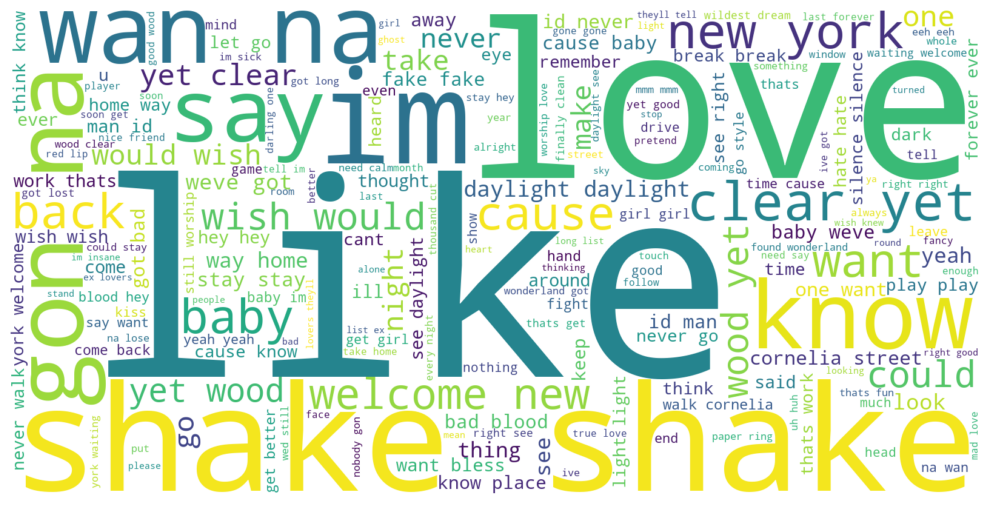

In [15]:
# Flatten the albums_lyrics_cleaned list
flat_list = [word for lyrics in albums_lyrics_cleaned for word in lyrics]

# Generate a word cloud text
wordcloud_text = ' '.join(flat_list)

# Generate a word cloud image with additional customizations
wordcloud = WordCloud(
    width=1600, height=800,  # Higher resolution
    background_color='white',
    max_words=200,  # Maximum number of words displayed
    stopwords=stop_words,  # Assuming 'stop_words' is defined
    colormap='viridis',  # Color scheme
    contour_width=3, contour_color='steelblue'  # Optional contour for the words
).generate(wordcloud_text)

# Display the generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()


#### Most common bi-grams

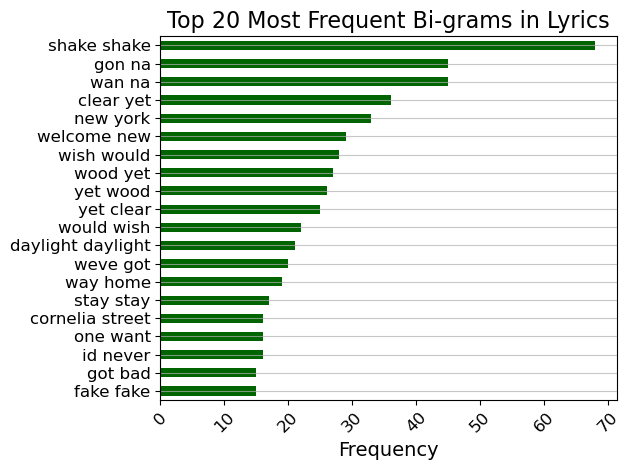

In [16]:
from nltk.util import ngrams

# a function for finding ngrams

def get_ngrams_from_series(series, n=2):
    # Concatenate all the lyrics into a single string and split into lines
    lines = ' '.join([' '.join(lyrics) for lyrics in series]).lower().split('\n')

    # Generate n-grams for each line and flatten the list of lists
    lgrams = [ngrams(l.split(), n) for l in lines if l]  # Skip empty lines
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    
    return [item for sublist in grams for item in sublist]

bi_grams = get_ngrams_from_series(albums_lyrics_cleaned, 2)

# Count the frequency of each bi-gram
bi_gram_freq = pd.Series(bi_grams).value_counts()

# Plot the top 20 most frequent bi-grams
bi_gram_freq[:20][::-1].plot(kind='barh', color='darkgreen')
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 20 Most Frequent Bi-grams in Lyrics', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)  # Adding a grid for the y-axis
plt.tight_layout()  # Adjusting the plot layout
plt.show()


#### Most common tri-grams

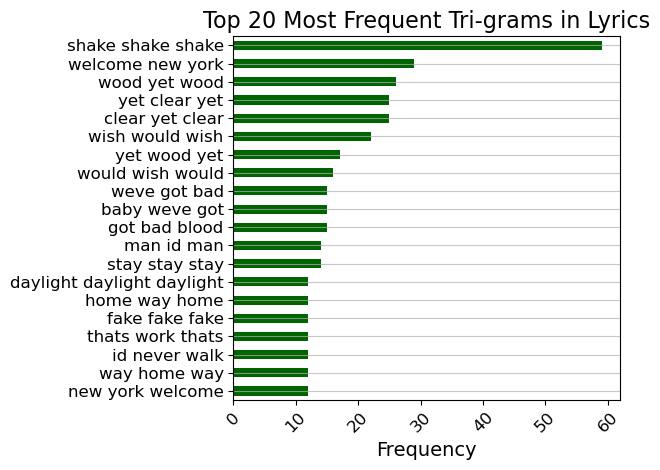

In [17]:
tri_grams = get_ngrams_from_series(albums_lyrics_cleaned, 3)

# Count the frequency of each tri-gram
tri_gram_freq = pd.Series(tri_grams).value_counts()

# Plot the top 20 most frequent tri-grams
tri_gram_freq[:20][::-1].plot(kind='barh', color='darkgreen')
plt.xlabel('Frequency', fontsize=14)
plt.title('Top 20 Most Frequent Tri-grams in Lyrics', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotating x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)  # Adding a grid for the y-axis
plt.tight_layout()  # Adjusting the plot layout
plt.show()

There are 1207 unique tokens
{'aglow': 0.005235602094240838, 'anything': 0.015706806282722512, 'apartment': 0.005235602094240838, 'bag': 0.005235602094240838, 'beat': 0.02617801047120419, 'blind': 0.02617801047120419, 'boy': 0.010471204188481676, 'bright': 0.02617801047120419, 'broken': 0.005235602094240838, 'change': 0.005235602094240838, 'coat': 0.005235602094240838, 'could': 0.015706806282722512, 'crazy': 0.005235602094240838, 'crowd': 0.005235602094240838, 'dance': 0.015706806282722512, 'drawer': 0.005235602094240838, 'drive': 0.005235602094240838, 'dropped': 0.005235602094240838, 'else': 0.005235602094240838, 'ever-changing': 0.005235602094240838, 'everybody': 0.010471204188481676, 'first': 0.005235602094240838, 'floor': 0.005235602094240838, 'forevermore': 0.010471204188481676, 'girl': 0.010471204188481676, 'great': 0.005235602094240838, 'guessing': 0.005235602094240838, 'heard': 0.005235602094240838, 'heart': 0.005235602094240838, 'heartbeat': 0.005235602094240838, 'kaleidoscope

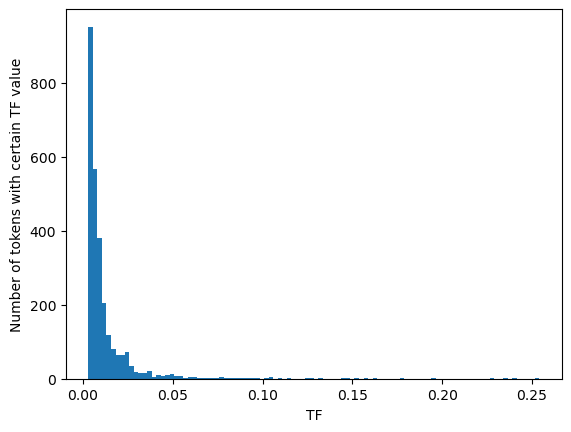

In [18]:
FreqDict = defaultdict(int)
for tList in albums_lyrics_cleaned:
    unique_list = list(np.unique(tList))
    for token in unique_list:
        FreqDict[token] += 1
        
print('There are',len(FreqDict),'unique tokens')


#dictionary from gensim library = keys are: 1, 2, 3, ..., number of tokens; values are tokens' names
dictionary = corpora.Dictionary(albums_lyrics_cleaned) 

#corpus from gensim library consists of so called bows
#every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
corpus = [dictionary.doc2bow(text) for text in albums_lyrics_cleaned]


def TF(dictionary, corpus, which_text):
    
    #corpus from gensim library consists of so called bows
    #every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
    bow = dict(corpus[which_text])
    
    
    #dict_combined = keys are tokens' names; values are numbers of tokens' occurences in text
    bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())
    
    TFdictionary = {}
    bow_count = sum(bow_dict_combined.values()) #number of tokens in text
    
    for word, count in bow_dict_combined.items():
        TFdictionary[word] = count/bow_count
    
    return TFdictionary

print(TF(dictionary, corpus, 0)) #Term Frequency in document no. 0

d = {} # this dictionary will include all tokens names as keys and all TF values found for those tokens in a form of list

for i in range(0,len(corpus)): # for each text
    data = TF(dictionary, corpus, i) # calculates TF for all tokens in text

    for token, tf in data.items(): # for each token and calculated TF
        d.setdefault(token, []).append(tf) # fills dictionary named 'd'

tf_values = [item for sublist in list(d.values()) for item in sublist]

#now, simple histogram
plt.hist(tf_values, bins=100)
plt.xlabel('TF')
plt.ylabel('Number of tokens with certain TF value')
plt.show()

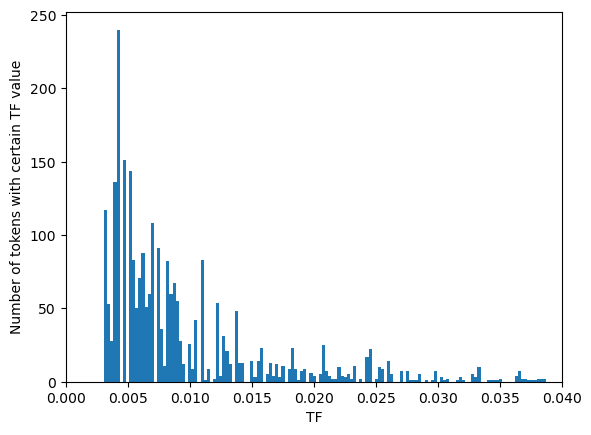

In [19]:
plt.hist(tf_values, bins=1000)
plt.xlabel('TF')
plt.ylabel('Number of tokens with certain TF value')
plt.xlim([0, 0.04]) # limit on x axis
plt.show()

In [20]:
mean_tf = {}

for token, tfs in d.items(): # takes from dictionary 'd' all tokens' names with all TF values assigned to a name
                             # next, it saves tokens' names together with mean values of TF assigned tokens
    mean_tf[token] = statistics.mean(tfs)
mean_tf

{'aglow': 0.005235602094240838,
 'anything': 0.02009830110054493,
 'apartment': 0.004782303211622584,
 'bag': 0.004782303211622584,
 'beat': 0.016165928312525172,
 'blind': 0.025210217356814217,
 'boy': 0.012263009366139731,
 'bright': 0.02617801047120419,
 'broken': 0.005235602094240838,
 'change': 0.005235602094240838,
 'coat': 0.005967869374258384,
 'could': 0.015222164288038964,
 'crazy': 0.00867840710772648,
 'crowd': 0.005648104077423449,
 'dance': 0.00986953217361932,
 'drawer': 0.005235602094240838,
 'drive': 0.005880912094088376,
 'dropped': 0.005235602094240838,
 'else': 0.010678236614556351,
 'ever-changing': 0.005235602094240838,
 'everybody': 0.008683877956309803,
 'first': 0.006579173901028179,
 'floor': 0.004782303211622584,
 'forevermore': 0.010471204188481676,
 'girl': 0.025652129007180984,
 'great': 0.005263303692623064,
 'guessing': 0.005235602094240838,
 'heard': 0.008186311029809839,
 'heart': 0.008539723378160806,
 'heartbeat': 0.01538375849392893,
 'kaleidoscope'

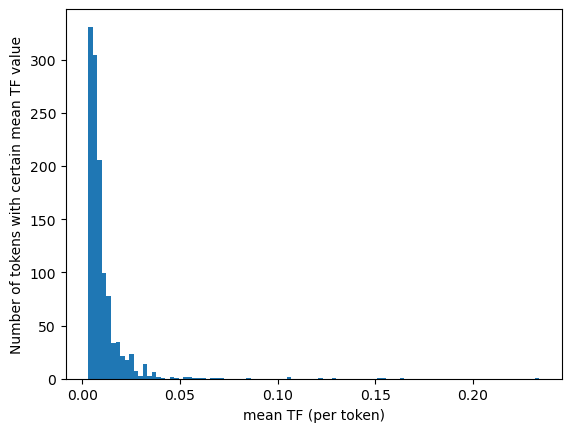

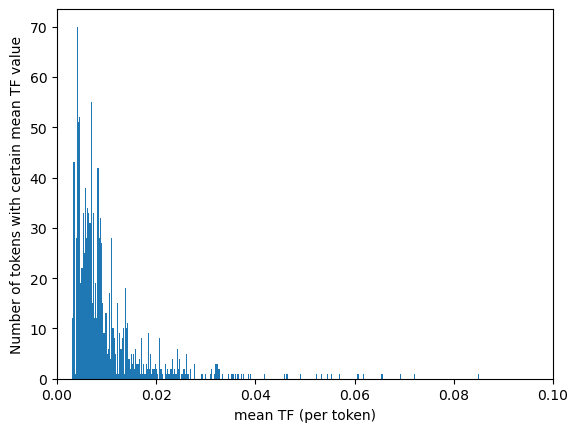

In [21]:
mean_tf_values = list(mean_tf.values()) # makes dictionary's values a list

plt.hist(mean_tf_values, bins=100) # another histogram
plt.xlabel('mean TF (per token)')
plt.ylabel('Number of tokens with certain mean TF value')
plt.show()

plt.hist(mean_tf_values, bins=1000)
plt.xlabel('mean TF (per token)')
plt.ylabel('Number of tokens with certain mean TF value')
plt.xlim([0, 0.1]) # limits applied to x axis
plt.show()

In [22]:
albums = pd.concat([merged_album1, merged_album2]).reset_index(drop=True)
albums_lyrics_joined = [' '.join(lyrics) for lyrics in albums_lyrics_cleaned]
tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tf_vectorizer = CountVectorizer(encoding = 'utf-8', # if bytes to analyze, this encoding will be used
                                decode_error = 'strict', # if we want to get an error in case of encoding error
                                strip_accents = None, # if we want to do something we accents
                                
                                lowercase = True, # all letters to lower case 
                                stop_words = stop_words, # what stopwords do we want to use 
                                ngram_range = (1, 3), # what kind of ngrams do we want 
                                
                                max_df = 0.8, # filtering with document frequency
                                min_df = 2, # filtering with document frequency
                                max_features = None, # if we want to use only the tokens with top document frequency
                                
                                tokenizer = tokenizer.tokenize # tokenizer
)

tf = tf_vectorizer.fit_transform(albums_lyrics_joined)
tf_feature_names = tf_vectorizer.get_feature_names_out() 

In [23]:
def generate_ngrams(text, ngram = 1):
    temp = zip(*[text[i:] for i in range(0,ngram)]) # set with pairs, three, ..., ns of tokens
    ans = [' '.join(ngram) for ngram in temp] # joins the elements in strings
    ans = pd.Series(ans).map(lambda x: re.sub(" ", '_', x)) # replaces spaces with '_'
    return list(ans)

# UMass score from: https://stackoverflow.com/questions/69730428/how-do-i-find-coherence-score-for-lsa-and-lda-for-sklearn-models
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

# UCI score prepared basing on the above
def get_uci_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dj, Dij = col_i.sum(), col_j.sum(), col_ij.sum()
    return math.log((Dij + 1) / (Di*Dj))

# using NPMI instead of PMI in UCI score
def get_uci_npmi_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dj, Dij = col_i.sum(), col_j.sum(), col_ij.sum()
    return (math.log((Dij + 1) / (Di*Dj))) / (-math.log(Dij+1)+1) # slight modifications to avoid log(0) or dividing with 0

def get_topic_coherence(dt_matrix, topic, n_top_words, coherence_type):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    if(coherence_type == "uci"):
        for j_index in range(0, len(topic_top)):
            for i_index in range(0, j_index - 1):
                i = topic_top[i_index][1]
                j = topic_top[j_index][1]
                coherence += get_uci_score(dt_matrix, i, j)
    if(coherence_type == "uci_npmi"):
        for j_index in range(0, len(topic_top)):
            for i_index in range(0, j_index - 1):
                i = topic_top[i_index][1]
                j = topic_top[j_index][1]
                coherence += get_uci_npmi_score(dt_matrix, i, j)
    if(coherence_type == "umass"):
        for j_index in range(0, len(topic_top)):
            for i_index in range(0, j_index - 1):
                i = topic_top[i_index][1]
                j = topic_top[j_index][1]
                coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words, coherence_type):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words, coherence_type)
    return total_coherence / len(topics)


def DF(corpus, dictionary):
    occurence = {}

    for i in range(0,len(corpus)):
    
        #corpus from gensim library consists of so called bows
        #every bow = keys are tokens' indexes; values are numbers of tokens' occurences in text
        bow = dict(corpus[i])
    
        #dict_combined = keys are tokens' names; values are numbers of tokens' occurences in text
        bow_dict_combined = dict((dictionary[key], value) for (key, value) in bow.items())

        # creates a dictionary where keys are tokens' names and values are lists of tokens' non-zero counts in texts
        for token, count in bow_dict_combined.items():
            occurence.setdefault(token, []).append(count)

    DFdictionary = {}
        
    # based on tokens' counts dictionary woth tokens' names and IDF values is computed
    for token, counts in occurence.items():
        DFdictionary[token] = len(counts)/len(corpus)
        
    return(DFdictionary)

## LSA & LDA

In [24]:
for i in range(0,len(albums_lyrics_cleaned)):
    unigrams = albums_lyrics_cleaned[i]
    bigrams = generate_ngrams(albums_lyrics_cleaned[i], ngram = 2)
    trigrams = generate_ngrams(albums_lyrics_cleaned[i], ngram = 3)
    
    text = []
    text.append(unigrams)
    text.append(bigrams)
    text.append(trigrams)
    
    albums_lyrics_cleaned[i] = [item for sublist in text for item in sublist] 


lsa = TruncatedSVD(n_components = 5, #number of topics
                   n_iter = 25, #number of iterations, more iterations -> more accurate but slower
                                #we should rather use something around 100 but it would take more time...
                   random_state = 42) #random seed in aim of reproducibility

model = lsa.fit_transform(tf) #fitting model on data

for index, component in enumerate(lsa.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic




Topic 0:  ['shake', 'na', 'gon', 'gon na', 'fake', 'mmm', 'hate', 'play', 'break', 'im']
Topic 1:  ['yet', 'clear', 'love', 'like', 'good', 'got', 'want', 'know', 'never', 'back']
Topic 2:  ['yet', 'clear', 'shake', 'fake', 'mmm', 'remember', 'break', 'play', 'hate', 'good']
Topic 3:  ['new', 'new york', 'york', 'waiting', 'blind', 'beat', 'light', 'never', 'shake', 'anything']
Topic 4:  ['thats', 'want', 'girl', 'id', 'would', 'never', 'get', 'work', 'ever', 'man']


Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


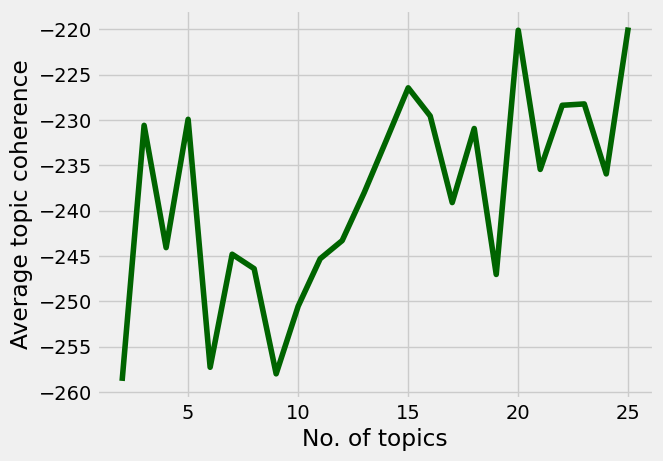

In [25]:
dictionary = corpora.Dictionary(albums_lyrics_cleaned) # using the column with preprocessed data in form of tokens 
                                                # in lists not as strings
corpus = [dictionary.doc2bow(text) for text in albums_lyrics_cleaned] # same as above

DFdictionary = DF(corpus, dictionary)
len(DFdictionary)
dict(sorted(DFdictionary.items(), key=lambda item: item[1], reverse=True))

topic_coherence_specific = []

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lda.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25, 'umass')
    
    topic_coherence_specific.append([avg_coherence, n_topics])
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

# We have to create new working directory
current_directory = os.getcwd()
outputs_directory = os.path.join(current_directory, 'outputs')
if not os.path.exists(outputs_directory):
    os.makedirs(outputs_directory)
    print("Created directory:", outputs_directory)
    
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# Now you can save your file in this directory
save_object(topic_coherence_specific_df, os.path.join(outputs_directory, 'topic_coherence_lda_countvectorizer.pkl'))

plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'], color = 'darkgreen')
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()


Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


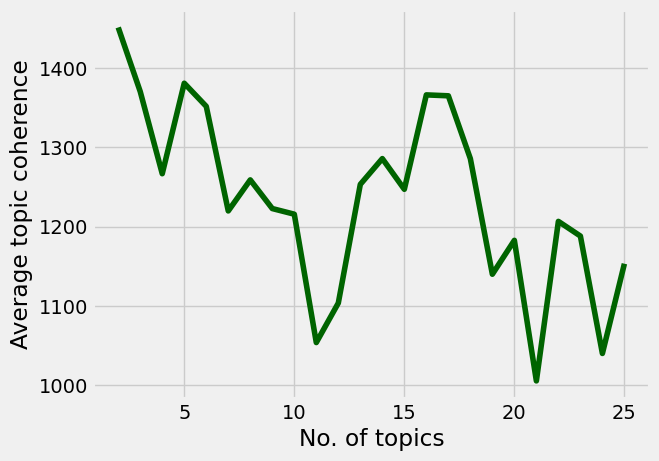

In [27]:
dictionary = corpora.Dictionary(albums_lyrics_cleaned) # using the column with preprocessed data in form of tokens 
                                                # in lists not as strings
corpus = [dictionary.doc2bow(text) for text in albums_lyrics_cleaned] # same as above

DFdictionary = DF(corpus, dictionary)
len(DFdictionary)
dict(sorted(DFdictionary.items(), key=lambda item: item[1], reverse=True))

topic_coherence_specific = []

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lda.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25, 'uci_npmi')
    
    topic_coherence_specific.append([avg_coherence, n_topics])
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

# We have to create new working directory
current_directory = os.getcwd()
outputs_directory = os.path.join(current_directory, 'outputs')
if not os.path.exists(outputs_directory):
    os.makedirs(outputs_directory)
    print("Created directory:", outputs_directory)
    
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# Now you can save your file in this directory
save_object(topic_coherence_specific_df, os.path.join(outputs_directory, 'topic_coherence_lda_countvectorizer.pkl'))

plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'], color = 'darkgreen')
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()


Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25


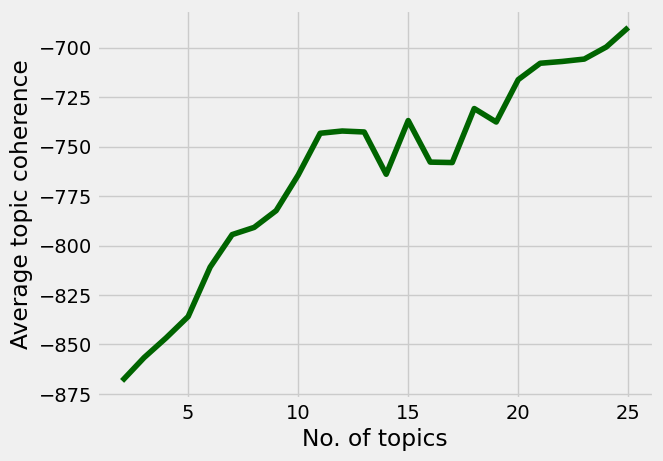

In [26]:
dictionary = corpora.Dictionary(albums_lyrics_cleaned) # using the column with preprocessed data in form of tokens 
                                                # in lists not as strings
corpus = [dictionary.doc2bow(text) for text in albums_lyrics_cleaned] # same as above

DFdictionary = DF(corpus, dictionary)
len(DFdictionary)
dict(sorted(DFdictionary.items(), key=lambda item: item[1], reverse=True))

topic_coherence_specific = []

for n_topics in range(2,26,1):
    
    print('Trying parameters:', n_topics)
    
    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 42) 
    #less iterations used above to not wait till tomorrow, results will be less precise though
                
    lda.fit_transform(tf)
                
    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25, 'uci')
    
    topic_coherence_specific.append([avg_coherence, n_topics])
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

# We have to create new working directory
current_directory = os.getcwd()
outputs_directory = os.path.join(current_directory, 'outputs')
if not os.path.exists(outputs_directory):
    os.makedirs(outputs_directory)
    print("Created directory:", outputs_directory)
    
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# Now you can save your file in this directory
save_object(topic_coherence_specific_df, os.path.join(outputs_directory, 'topic_coherence_lda_countvectorizer.pkl'))

plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df['n_topics'],topic_coherence_specific_df['avg_coherence'], color = 'darkgreen')
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()


In [28]:
topic_coherence_specific_df.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
0,1451.470812,2
3,1381.066694,5
1,1370.546439,3
14,1366.350480,16
15,1365.176298,17
4,1351.854287,6
12,1285.893636,14
16,1285.859543,18
2,1266.810701,4


In [29]:
lsa = TruncatedSVD(n_components = 10, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['shake', 'na', 'gon', 'gon na', 'fake', 'mmm', 'hate', 'play', 'break', 'im']
Topic 1:  ['yet', 'clear', 'love', 'like', 'good', 'got', 'want', 'know', 'never', 'back']
Topic 2:  ['yet', 'clear', 'shake', 'fake', 'mmm', 'remember', 'break', 'play', 'hate', 'good']
Topic 3:  ['new', 'new york', 'york', 'waiting', 'blind', 'beat', 'light', 'never', 'shake', 'anything']
Topic 4:  ['thats', 'want', 'girl', 'id', 'would', 'never', 'get', 'work', 'ever', 'man']
Topic 5:  ['got', 'weve', 'baby', 'think', 'hey', 'know', 'bad', 'want', 'stay', 'cause baby']
Topic 6:  ['stay', 'want', 'hey', 'hey hey', 'hey hey hey', 'thats', 'say', 'girl', 'let', 'say want']
Topic 7:  ['stay', 'hey', 'would', 'id', 'never', 'hey hey', 'back', 'man', 'hey hey hey', 'right']
Topic 8:  ['girl', 'thats', 'would', 'weve', 'got', 'work', 'back', 'ever', 'get', 'shake']
Topic 9:  ['man', 'id', 'light', 'way home', 'way', 'silence', 'home', 'one', 'want', 'stay']


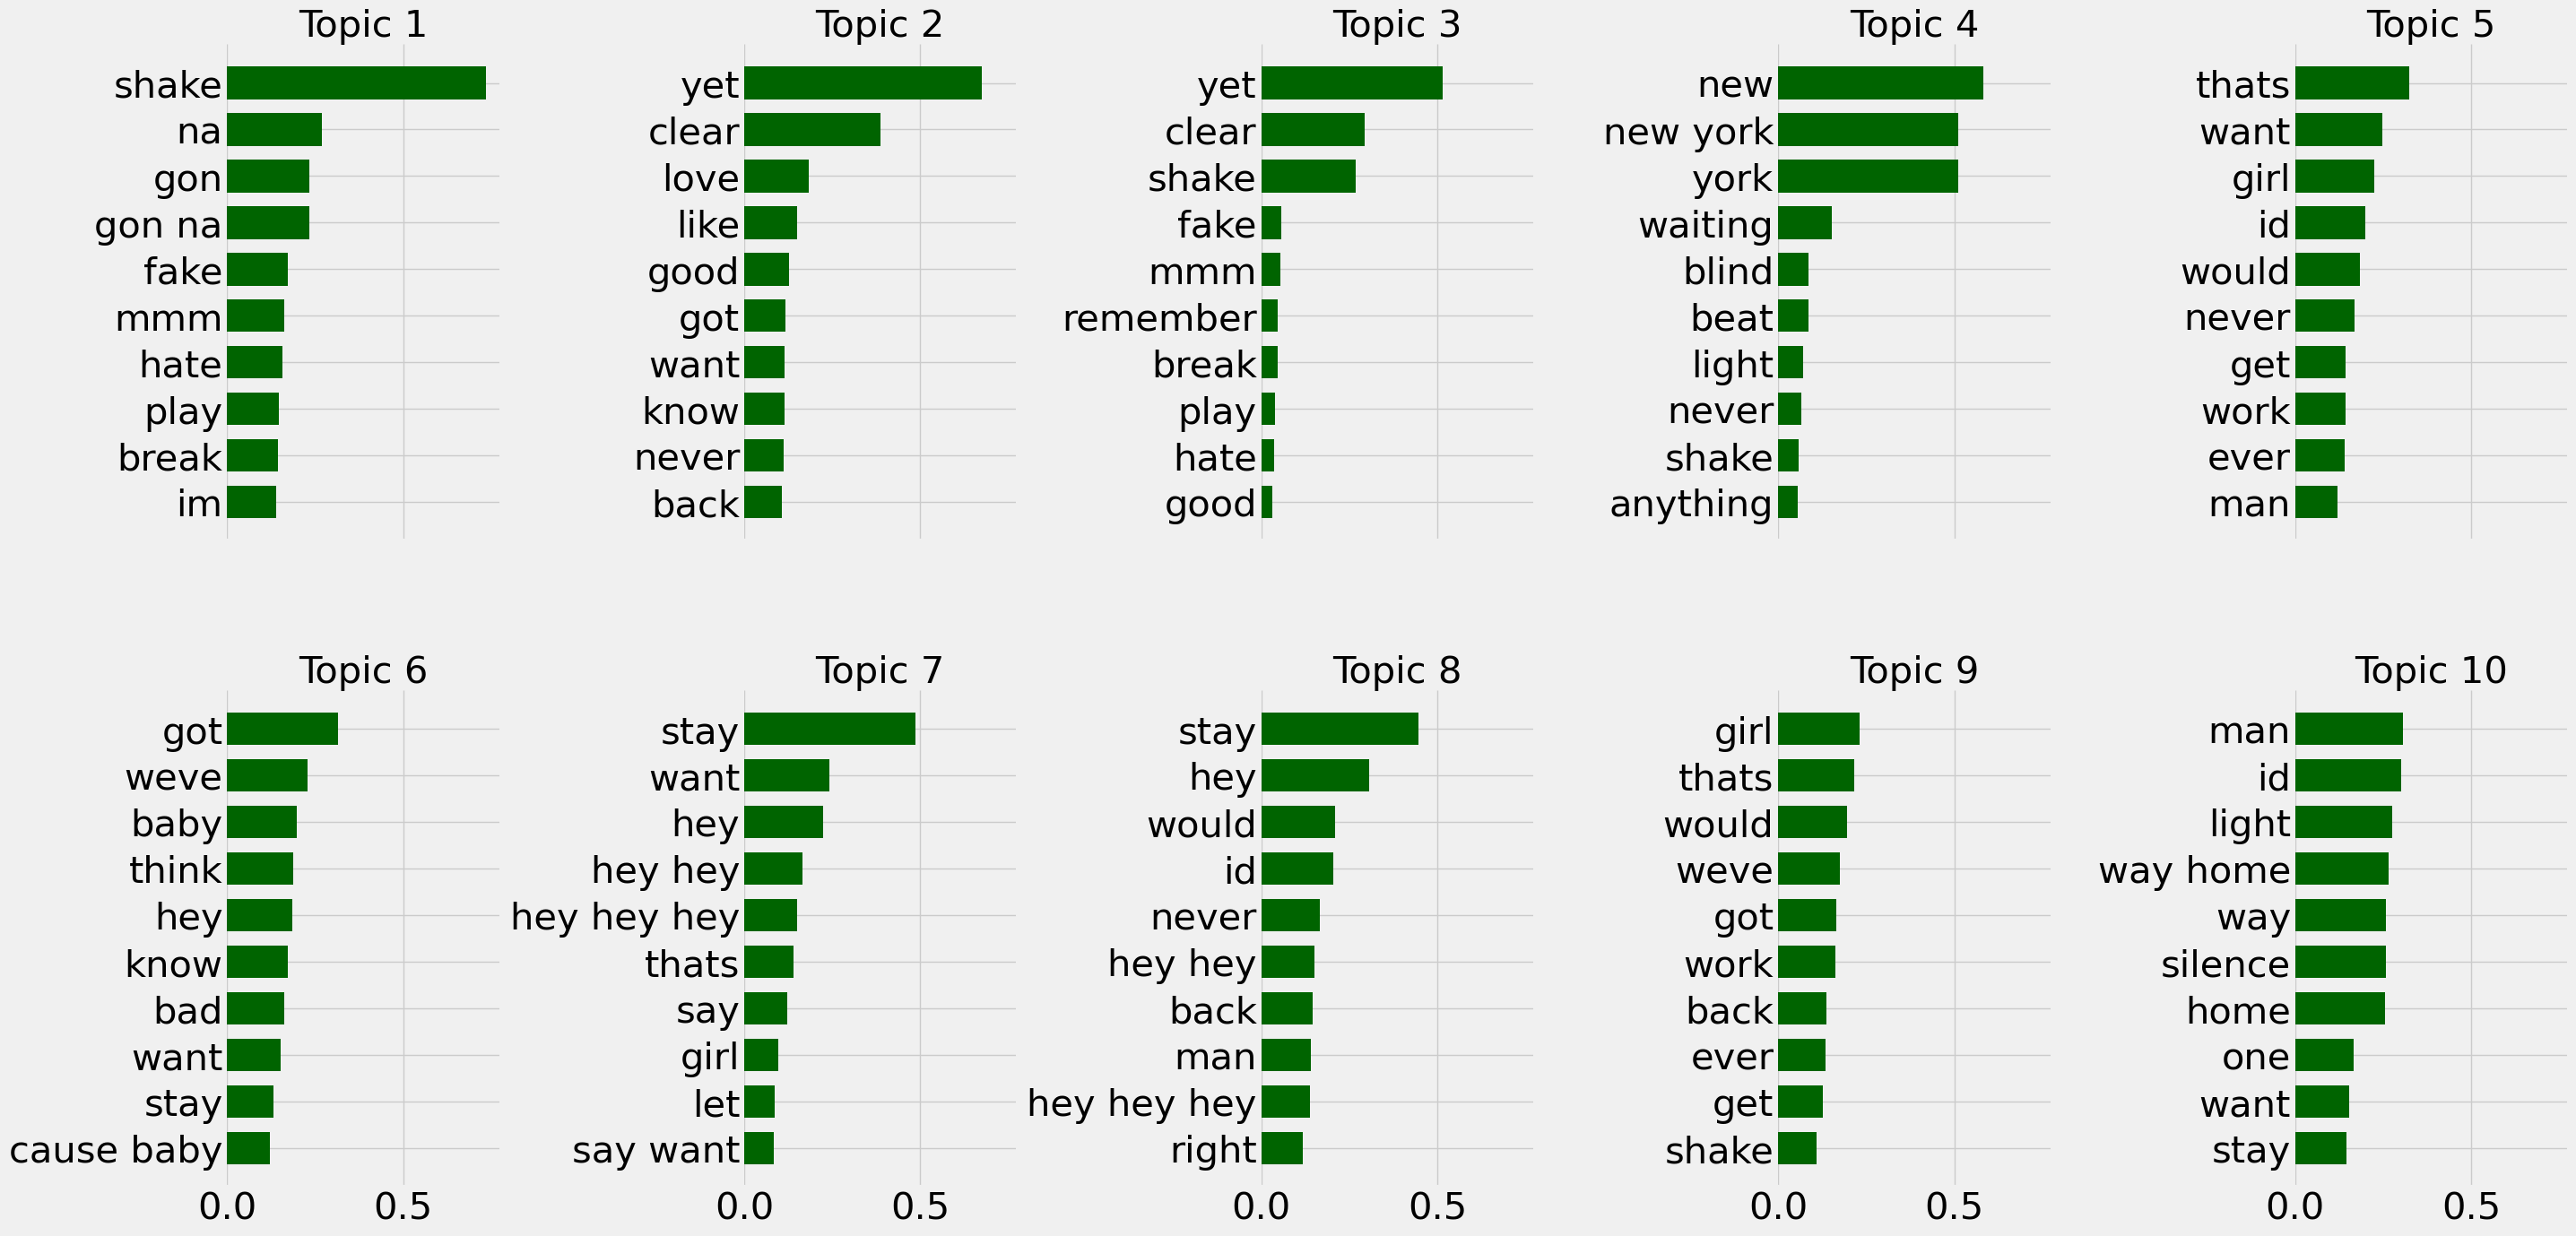

In [30]:
def plot_top_words(model, feature_names, n_top_words, title = '', subplotx = 2, subploty = 5, size = (30, 15)):
    fig, axes = plt.subplots(subplotx, subploty, figsize=size, sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color = 'darkgreen')
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=30)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
plot_top_words(lsa, tf_feature_names, 10, title = '', subplotx = 2, subploty = 5)

In [31]:
lda = LatentDirichletAllocation(n_components = 8, 
                   random_state = 42)

model = lda.fit_transform(tf)

for index, component in enumerate(lda.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['yet', 'clear', 'good', 'think', 'remember', 'came', 'im', 'could', 'gone', 'month']
Topic 1:  ['love', 'know', 'see', 'go', 'na', 'bad', 'place', 'back', 'let', 'wan']
Topic 2:  ['would', 'right', 'back', 'never', 'knew', 'come', 'good', 'mad', 'right right', 'make']
Topic 3:  ['got', 'man', 'id', 'cause', 'weve', 'go', 'bad', 'baby', 'say', 'never']
Topic 4:  ['shake', 'gon na', 'gon', 'na', 'fake', 'mmm', 'hate', 'play', 'break', 'cause']
Topic 5:  ['never', 'new', 'york', 'new york', 'thats', 'girl', 'street', 'like', 'walk', 'ever']
Topic 6:  ['like', 'na', 'love', 'know', 'stay', 'baby', 'im', 'wan', 'wan na', 'want']
Topic 7:  ['want', 'right', 'one', 'home', 'see', 'light', 'yeah', 'way', 'silence', 'way home']


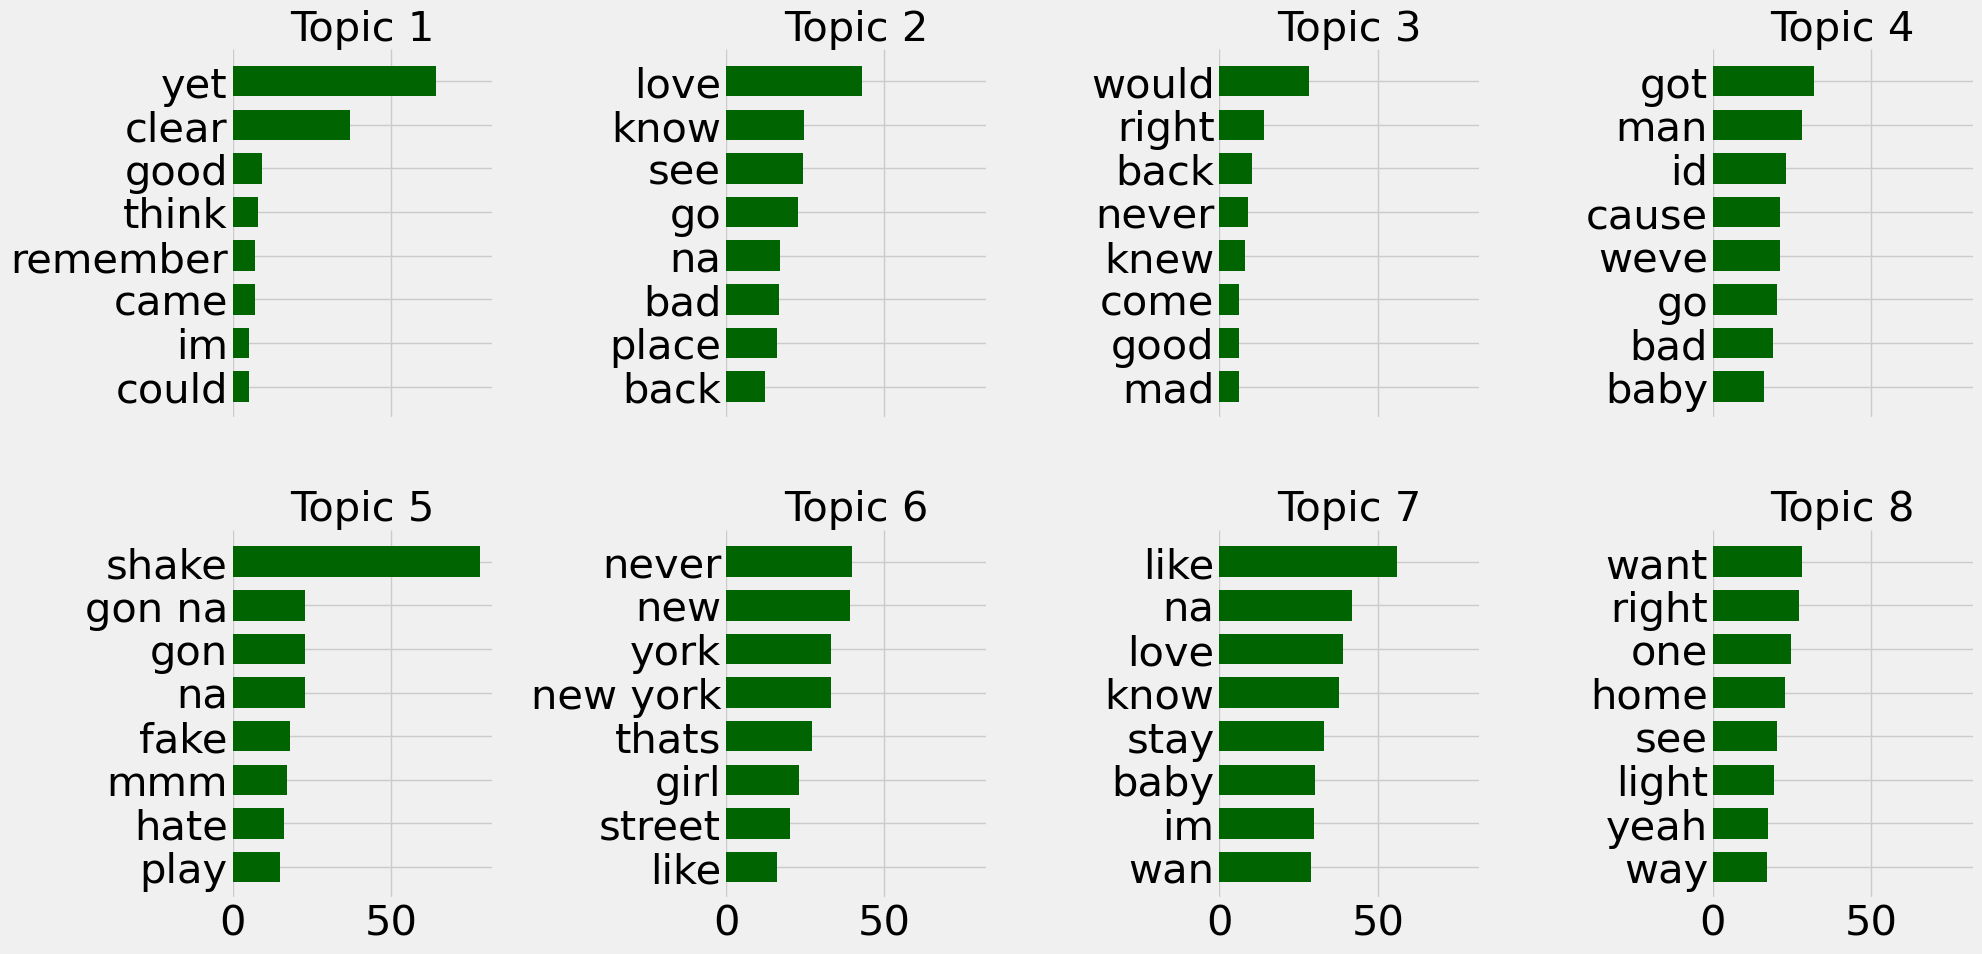

In [32]:
plot_top_words(lda, tf_feature_names, 8, title = '', subplotx = 2, subploty = 4, size = (20, 10))

Topic 0:  ['shake', 'na', 'gon', 'gon na', 'fake', 'mmm', 'hate', 'play', 'break', 'im']
Topic 1:  ['yet', 'clear', 'love', 'like', 'good', 'got', 'want', 'know', 'never', 'back']
Topic 2:  ['yet', 'clear', 'shake', 'fake', 'mmm', 'remember', 'break', 'play', 'hate', 'good']
Topic 3:  ['new', 'york', 'new york', 'waiting', 'blind', 'beat', 'light', 'never', 'shake', 'anything']
Topic 4:  ['thats', 'want', 'girl', 'id', 'would', 'never', 'get', 'work', 'ever', 'man']
Topic 5:  ['got', 'weve', 'baby', 'think', 'hey', 'know', 'bad', 'want', 'stay', 'cause baby']
Topic 6:  ['stay', 'want', 'hey', 'hey hey', 'hey hey hey', 'thats', 'say', 'girl', 'let', 'say want']
Topic 7:  ['stay', 'hey', 'would', 'id', 'never', 'hey hey', 'back', 'man', 'hey hey hey', 'right']


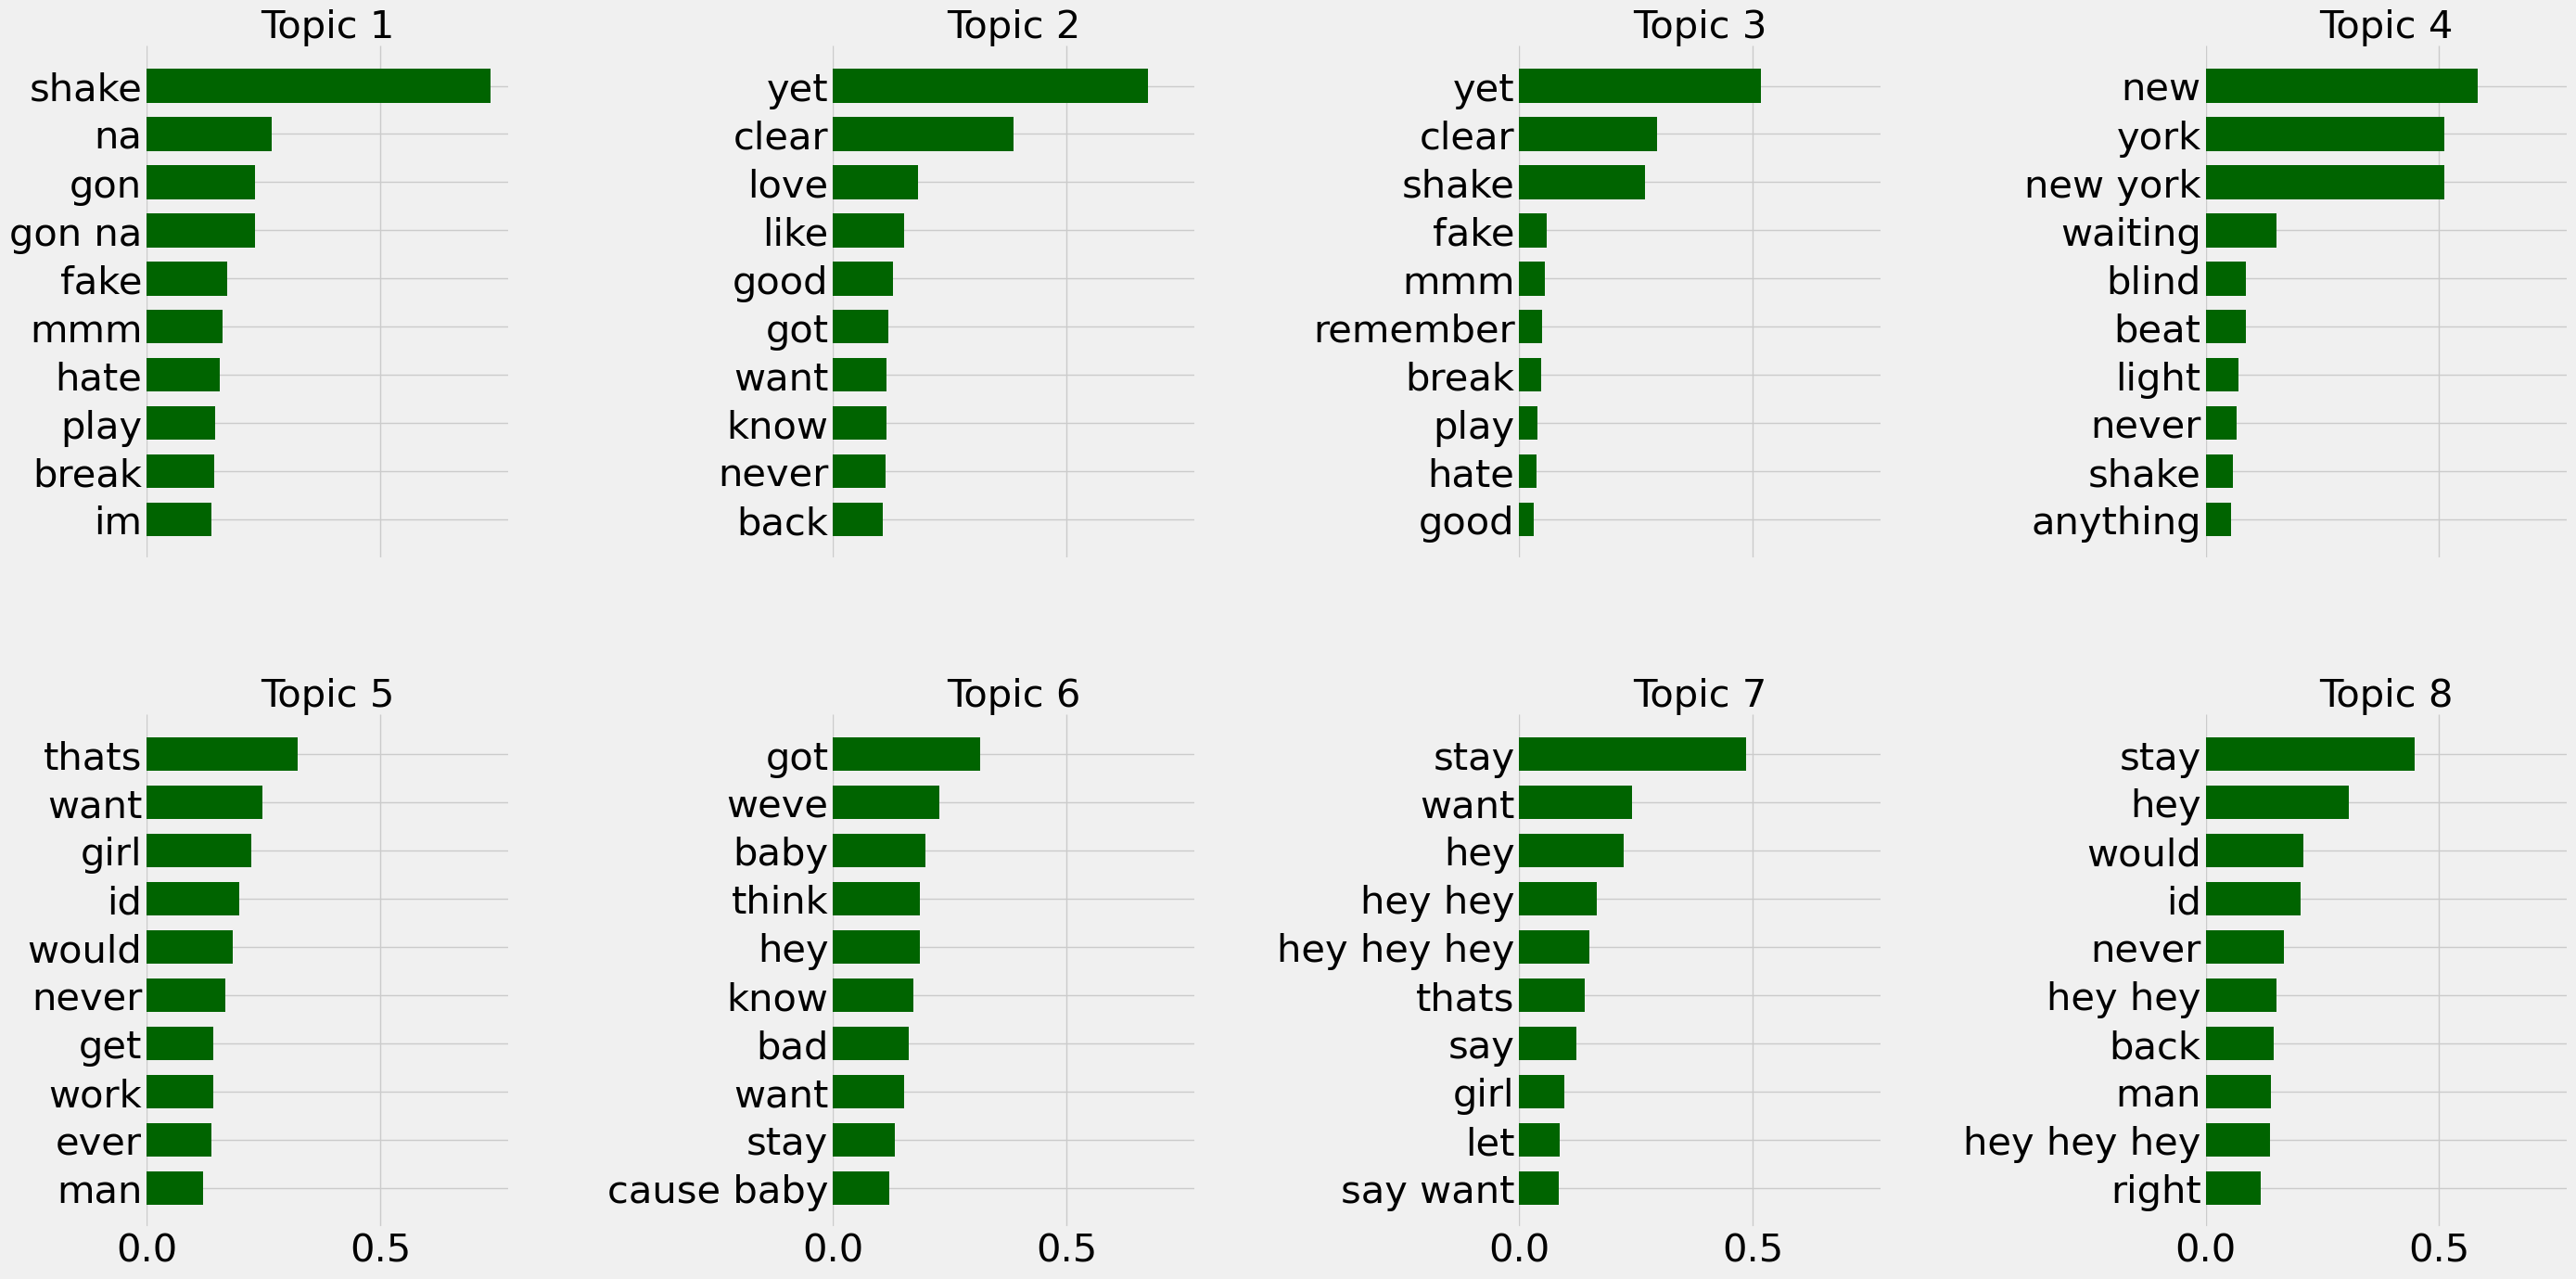

In [33]:
lsa = TruncatedSVD(n_components = 8, 
                   n_iter = 25,
                   random_state = 42)

model = lsa.fit_transform(tf)

for index, component in enumerate(lsa.components_):
    zipped = zip(tf_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    
    print("Topic "+str(index)+": ",top_terms_list)

plot_top_words(lsa, tf_feature_names, 10, title = '', subplotx = 2, subploty = 4)

## PLSA

In [34]:
plsa = NMF(n_components = 10, # number of topics
           max_iter = 25, # maximum number of iterations to be made
           init = None, # what W and H should be the 'staring guess'
                        # possible options depend on sparseness or 
                        # number of 0s there; {'random', 'nndsvd',
                        # 'nndsvda', 'nndvdar', 'custom', None};
                        # None means either 'nndsvda' or 'random' 
                        # which depends on sample and feature sizes
           solver = 'mu', # Multiplicative Update ('mu')
           beta_loss = 'kullback-leibler', # what type of distance metric should be minimized;
                                           # we aim at PLSA, so it has to be 'kullback-leibler'
           # let us neglect regularization as we aim at PLSA
           alpha_W = 0,
           alpha_H = 'same',
           l1_ratio = 0,
           random_state = 42 # random seed in aim of reproducibility
          )
model = plsa.fit_transform(tf) # fitting model on data
for index, component in enumerate(plsa.components_): #taking model's components 
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights
    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['shake', 'gon', 'gon na', 'na', 'baby', 'fake', 'play', 'mmm', 'thats', 'im']
Topic 1:  ['yet', 'clear', 'baby', 'yeah', 'like', 'im', 'tell', 'good', 'every', 'new']
Topic 2:  ['know', 'na', 'go', 'got', 'like', 'see', 'love', 'wan', 'wan na', 'never']
Topic 3:  ['new', 'new york', 'york', 'love', 'waiting', 'blind', 'say', 'even', 'dream', 'wildest']
Topic 4:  ['thats', 'want', 'get', 'girl', 'one', 'work', 'like', 'still', 'ever', 'wed']
Topic 5:  ['love', 'would', 'never', 'back', 'street', 'id', 'walk', 'id never', 'right', 'gone']
Topic 6:  ['stay', 'hey', 'say', 'know', 'wan', 'wan na', 'na', 'place', 'hey hey', 'hey hey hey']
Topic 7:  ['right', 'could', 'see', 'nice', 'cut', 'take', 'cause', 'ever', 'friend', 'stay']
Topic 8:  ['got', 'weve', 'baby', 'cause', 'bad', 'better', 'like', 'think', 'never', 'need']
Topic 9:  ['man', 'id', 'way home', 'light', 'way', 'home', 'silence', 'love', 'im', 'sick']


In [35]:

topic_coherence_specific = []
for n_topics in range(2,26,1):
    print('Trying parameters:', n_topics)
    plsa = NMF(n_components = n_topics,
               max_iter = 25,
               init = None,
               solver = 'mu',
               beta_loss = 'kullback-leibler',
               alpha_W = 0,
               alpha_H = 'same',
               l1_ratio = 0,
               random_state = 42
              ) 
    plsa.fit_transform(tf)
    avg_coherence = get_average_topic_coherence(tf, plsa.components_, 25)
    topic_coherence_specific.append([avg_coherence, n_topics])
# below, we make the output (list) a pandas DataFrame with intuitive colnames
topic_coherence_specific_df_plsa = pd.DataFrame(topic_coherence_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})
save_object(topic_coherence_specific_df_plsa, 'outputs/topic_coherence_specific_df_plsa.pkl')
with open("outputs/topic_coherence_specific_df_plsa.pkl", "rb") as fp:
    topic_coherence_specific_df_plsa = pickle.load(fp)
plt.style.use("fivethirtyeight")
plt.plot(topic_coherence_specific_df_plsa['n_topics'],topic_coherence_specific_df_plsa['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

Trying parameters: 2


TypeError: get_average_topic_coherence() missing 1 required positional argument: 'coherence_type'

In [ ]:
topic_coherence_specific_df_plsa.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

,avg_coherence,n_topics
23,-207.170026,25
1,-209.766282,3
22,-213.251027,24
21,-216.874949,23
12,-220.229330,14
14,-221.572110,16
18,-222.015444,20
16,-223.380892,18
15,-223.478820,17


## BERTopic Model

In [36]:
topic_model = BERTopic(language="english", vectorizer_model=tf_vectorizer, calculate_probabilities=True, verbose=True, min_topic_size = 2, nr_topics = 10)
topics, probs = topic_model.fit_transform(albums_lyrics_joined)

2024-01-18 17:49:59,874 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2024-01-18 17:50:05,749 - BERTopic - Embedding - Completed ✓
2024-01-18 17:50:05,750 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-18 17:50:14,054 - BERTopic - Dimensionality - Completed ✓
2024-01-18 17:50:14,054 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-18 17:50:14,105 - BERTopic - Cluster - Completed ✓
2024-01-18 17:50:14,106 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-18 17:50:14,164 - BERTopic - Representation - Completed ✓
2024-01-18 17:50:14,164 - BERTopic - Topic reduction - Reducing number of topics
2024-01-18 17:50:14,166 - BERTopic - Topic reduction - Reduced number of topics from 8 to 8


In [37]:
# Create a DataFrame with document information
df2 = pd.DataFrame(topic_model.get_document_info(albums_lyrics_joined))

df2['album_name'] = albums['album_name']
df2['track_title'] = albums['track_title']
df2.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,album_name,track_title
0,walking crowd village aglow kaleidoscope loud ...,4,4_york_new york_new_street,"[york, new york, new, street, never, walk, boy...",[go driving scooter uh know round london id lo...,york - new york - new - street - never - walk ...,0.285017,True,1989 (Deluxe),Welcome to New York
1,nice meet could show incredible thing magic ma...,5,5_yeah_tell_summer_baby,"[yeah, tell, summer, baby, every, cruel, come,...",[bored tired everything wait train coming show...,yeah - tell - summer - baby - every - cruel - ...,1.000000,True,1989 (Deluxe),Blank Space
2,midnight come pick headlight long drive could ...,3,3_cut_never_time cause_enough,"[cut, never, time cause, enough, come, got, ta...",[saying goodbye death thousand cut flashback w...,cut - never - time cause - enough - come - got...,1.000000,True,1989 (Deluxe),Style
3,looking seems simple lying couch remember took...,-1,-1_yet_clear_weve_need,"[yet, clear, weve, need, right, still, wan, wa...",[moon high like friend night first met went ho...,yet - clear - weve - need - right - still - wa...,0.007072,True,1989 (Deluxe),Out of the Woods
4,hey hey hey hey hey hey hey hey hey hey hey he...,0,0_shake_would_thats_stay,"[shake, would, thats, stay, hate, girl, hey, f...",[car window pas street memory start say past d...,shake - would - thats - stay - hate - girl - h...,1.000000,False,1989 (Deluxe),All You Had to Do Was Stay


In [38]:
print(set(topics))  # This should display a set of unique topic numbers


{0, 1, 2, 3, 4, 5, 6, -1}


In [39]:
from collections import Counter

# Get topic information
topic_info = topic_model.get_topic_info()

# Extracting words from all topics
all_words = []
for index, row in topic_info.iterrows():
    words = row['Representation']
    all_words.extend(words)

# Count the frequency of each word
word_counts = Counter(all_words)

# Identify and print repetitive words
print("Repetitive Words:")
for word, count in word_counts.items():
    if count > 1:  # Adjust this threshold as needed
        print(f"Word: {word}, Count: {count}")
        
topic_info


Repetitive Words:
Word: wan, Count: 2
Word: wan na, Count: 2
Word: got, Count: 2
Word: take, Count: 2
Word: never, Count: 2
Word: come, Count: 2


,Topic,Count,Name,Representation,Representative_Docs
0,-1,9,-1_yet_clear_weve_need,"[yet, clear, weve, need, right, still, wan, wa...",[moon high like friend night first met went ho...
1,0,7,0_shake_would_thats_stay,"[shake, would, thats, stay, hate, girl, hey, f...",[car window pas street memory start say past d...
2,1,5,1_place_found_gone_came,"[place, found, gone, came, lost, forever, love...",[clear blue water high tide came brought could...
3,2,2,2_silence_way home_way_wildest dream,"[silence, way home, way, wildest dream, wildes...",[said `` let get town drive city away crowd ''...
4,3,2,3_cut_never_time cause_enough,"[cut, never, time cause, enough, come, got, ta...",[saying goodbye death thousand cut flashback w...
5,4,4,4_york_new york_new_street,"[york, new york, new, street, never, walk, boy...",[go driving scooter uh know round london id lo...
6,5,3,5_yeah_tell_summer_baby,"[yeah, tell, summer, baby, every, cruel, come,...",[bored tired everything wait train coming show...
7,6,2,6_man_id_win_sick,"[man, id, win, sick, okay, coming, fight, whol...",[know adore im crazier lost film scene waving ...


In [40]:
print("Number of topics:", len(topics))
print("Number of documents:", len(albums_lyrics_joined))


Number of topics: 34
Number of documents: 34


In [41]:
# Print words associated with the first few topics
for i in range(min(5, len(topic_model.get_topics()))):
    print(f"Topic {i}: {topic_model.get_topic(i)}")


Topic 0: [('shake', 0.1680034620857866), ('would', 0.0982682499615758), ('thats', 0.09264570303461843), ('stay', 0.08976639433861132), ('hate', 0.06822988078521784), ('girl', 0.06649346888515843), ('hey', 0.0630821042510116), ('fake', 0.06242107729958235), ('break', 0.05359037570438735), ('better', 0.05326942602967419)]
Topic 1: [('place', 0.1272674149836454), ('found', 0.09894174467871447), ('gone', 0.09845830140046827), ('came', 0.0950873340508999), ('lost', 0.08075944989870466), ('forever', 0.07525854956517923), ('lover', 0.05952829980207572), ('let', 0.059446808543796595), ('take', 0.05608409651013255), ('think', 0.05445766677116886)]
Topic 2: [('silence', 0.22618834435231075), ('way home', 0.2227789280484789), ('way', 0.20557292304336483), ('wildest dream', 0.1272081113354725), ('wildest', 0.1272081113354725), ('dream', 0.10644157381285212), ('feel', 0.08425230431170531), ('true love', 0.08425230431170531), ('hear', 0.08172787009863525), ('cheek say', 0.072504542395305)]
Topic 3: 

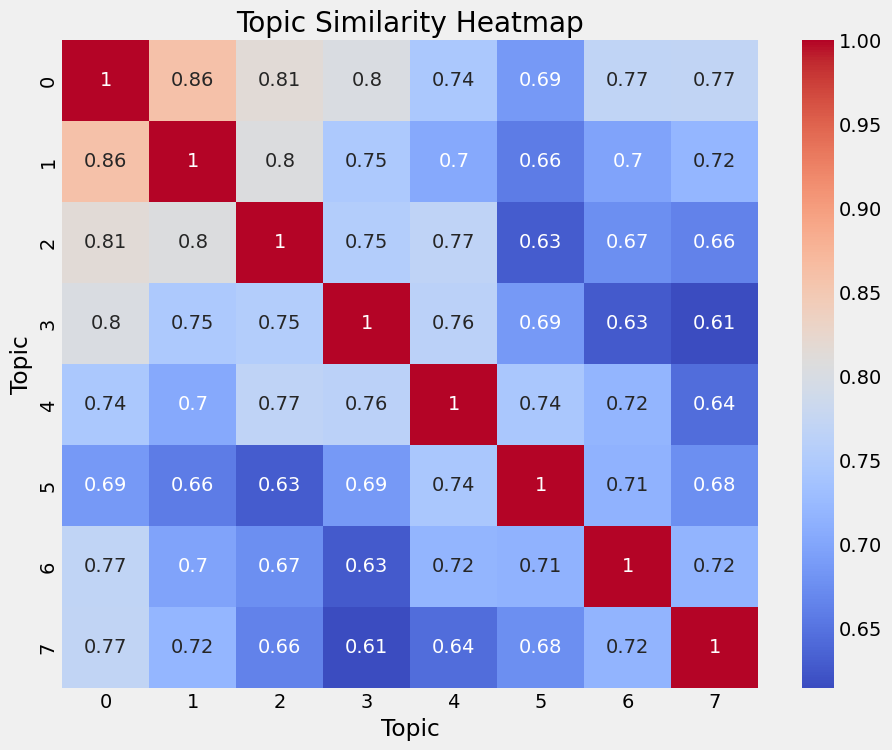

In [42]:
# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(topic_model.topic_embeddings_)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.title("Topic Similarity Heatmap")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()



In [43]:
try:
    topic_model.visualize_barchart()
except Exception as e:
    print(f"An error occurred during barchart visualization: {e}")

topic_model.visualize_barchart()


In [44]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each set of lyrics
albums['sentiments'] = [sia.polarity_scores(lyrics) for lyrics in albums_lyrics_joined]

# Extract compound scores and categorize sentiments
albums['compound'] = [sentiment['compound'] for sentiment in albums['sentiments']]
albums['sentiment_category'] = albums['compound'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\karla\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [45]:
albums.head()

,track_n,track_title,album_name,lyric,sentiments,compound,sentiment_category
0,1,Welcome to New York,1989 (Deluxe),"Walking through a crowd, the village is aglow ...","{'neg': 0.019, 'neu': 0.486, 'pos': 0.495, 'co...",0.9991,positive
1,2,Blank Space,1989 (Deluxe),"Nice to meet you, where you been? I could show...","{'neg': 0.236, 'neu': 0.533, 'pos': 0.231, 'co...",0.2249,positive
2,3,Style,1989 (Deluxe),"Midnight You come and pick me up, no headlight...","{'neg': 0.005, 'neu': 0.854, 'pos': 0.14, 'com...",0.9817,positive
3,4,Out of the Woods,1989 (Deluxe),Looking at it now It all seems so simple We we...,"{'neg': 0.034, 'neu': 0.566, 'pos': 0.4, 'comp...",0.9987,positive
4,5,All You Had to Do Was Stay,1989 (Deluxe),"(Hey, hey, hey) (Hey, hey, hey) (Hey, hey, hey...","{'neg': 0.013, 'neu': 0.645, 'pos': 0.342, 'co...",0.9949,positive


In [46]:
# Adding joined lyrics to the albums DataFrame
albums['lyrics_joined'] = albums_lyrics_joined

# Sort both dataframes by the lyrics column
albums_sorted = albums.sort_values(by='lyrics_joined')
df2_sorted = df2.sort_values(by='Document')

# Reset the index to align both dataframes
albums_sorted = albums_sorted.reset_index(drop=True)
df2_sorted = df2_sorted.reset_index(drop=True)

# Merge the dataframes
merged_df = pd.merge(albums_sorted, df2_sorted, left_on='lyrics_joined', right_on='Document')

# Drop the duplicate column ('Document') after merging
merged_df.drop('Document', axis=1, inplace=True)

merged_df.head()

,track_n,track_title_x,album_name_x,lyric,sentiments,compound,sentiment_category,lyrics_joined,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,album_name_y,track_title_y
0,12,I Know Places,1989 (Deluxe),"I, I, I, I, I, I, I, I-I I, I, I, I, I, I, I, ...","{'neg': 0.179, 'neu': 0.674, 'pos': 0.147, 'co...",-0.3400,negative,- - - stand hand waistline scene plain sight h...,1,1_place_found_gone_came,"[place, found, gone, came, lost, forever, love...",[clear blue water high tide came brought could...,place - found - gone - came - lost - forever -...,0.173150,True,1989 (Deluxe),I Know Places
1,9,Cornelia Street,Lover,We were in the backseat Drunk on something str...,"{'neg': 0.105, 'neu': 0.717, 'pos': 0.179, 'co...",0.9310,positive,backseat drunk something stronger drink bar ``...,4,4_york_new york_new_street,"[york, new york, new, street, never, walk, boy...",[go driving scooter uh know round london id lo...,york - new york - new - street - never - walk ...,0.253483,True,Lover,Cornelia Street
2,15,Afterglow,Lover,"I blew things out of proportion, now you're bl...","{'neg': 0.269, 'neu': 0.572, 'pos': 0.16, 'com...",-0.9633,negative,blew thing proportion blue put jail something ...,-1,-1_yet_clear_weve_need,"[yet, clear, weve, need, right, still, wan, wa...",[moon high like friend night first met went ho...,yet - clear - weve - need - right - still - wa...,0.416544,False,Lover,Afterglow
3,16,New Romantics,1989 (Deluxe),"We're all bored, we're all so tired of everyth...","{'neg': 0.148, 'neu': 0.468, 'pos': 0.383, 'co...",0.9968,positive,bored tired everything wait train coming show ...,5,5_yeah_tell_summer_baby,"[yeah, tell, summer, baby, every, cruel, come,...",[bored tired everything wait train coming show...,yeah - tell - summer - baby - every - cruel - ...,1.000000,True,1989 (Deluxe),New Romantics
4,12,Soon You’ll Get Better,Lover,The buttons of my coat were tangled in my hair...,"{'neg': 0.134, 'neu': 0.519, 'pos': 0.347, 'co...",0.9865,positive,button coat tangled hair doctor office lightin...,0,0_shake_would_thats_stay,"[shake, would, thats, stay, hate, girl, hey, f...",[car window pas street memory start say past d...,shake - would - thats - stay - hate - girl - h...,0.137188,False,Lover,Soon You’ll Get Better


   Topic  avg_compound                 sentiment_count
0     -1      0.513456  {'positive': 7, 'negative': 2}
1      0      0.049757  {'positive': 4, 'negative': 3}
2      1      0.281020  {'positive': 3, 'negative': 2}
3      2      0.982100                 {'positive': 2}
4      3      0.061150  {'positive': 1, 'negative': 1}
5      4      0.981450                 {'positive': 4}
6      5      0.098967  {'positive': 2, 'negative': 1}
7      6     -0.984400                 {'negative': 2}


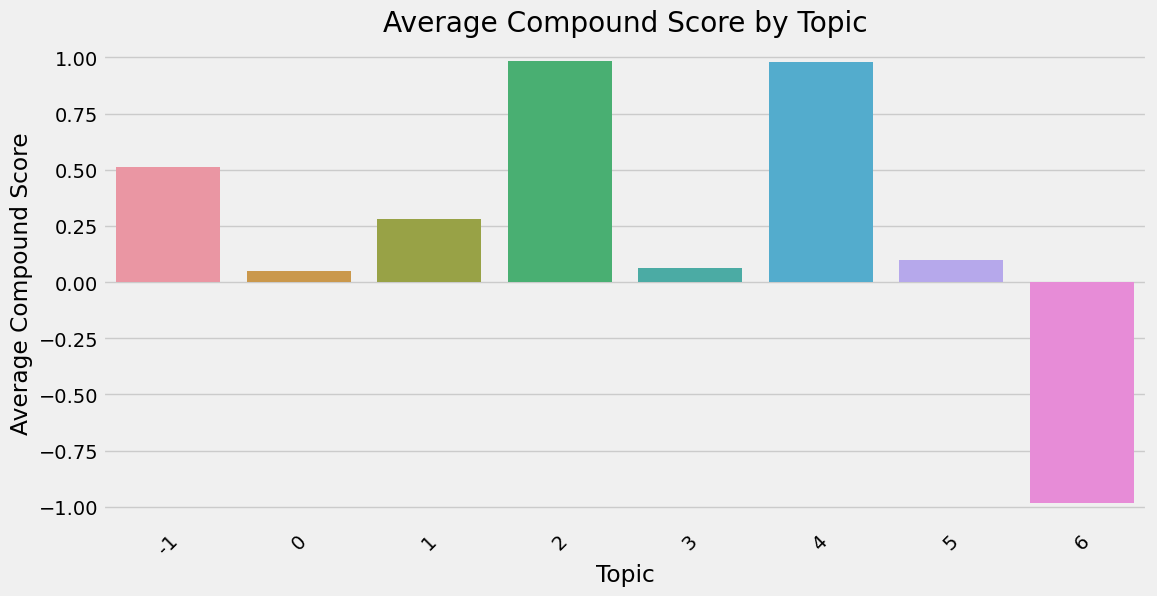

In [47]:
# Grouping by Topic and calculating mean sentiment scores and sentiment counts
topic_sentiment_analysis = merged_df.groupby('Topic').agg(
    avg_compound=('compound', 'mean'),  # Average compound score
    sentiment_count=('sentiment_category', lambda x: x.value_counts().to_dict())  # Count of sentiment categories
).reset_index()

# Displaying the result
print(topic_sentiment_analysis)

# Visualizing the average compound score for each topic
plt.figure(figsize=(12, 6))
sns.barplot(x='Topic', y='avg_compound', data=topic_sentiment_analysis)
plt.title('Average Compound Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Compound Score')
plt.xticks(rotation=45)
plt.show()



    album_name_x  avg_compound                  sentiment_count
0  1989 (Deluxe)      0.228887  {'positive': 10, 'negative': 6}
1          Lover      0.391817  {'positive': 13, 'negative': 5}


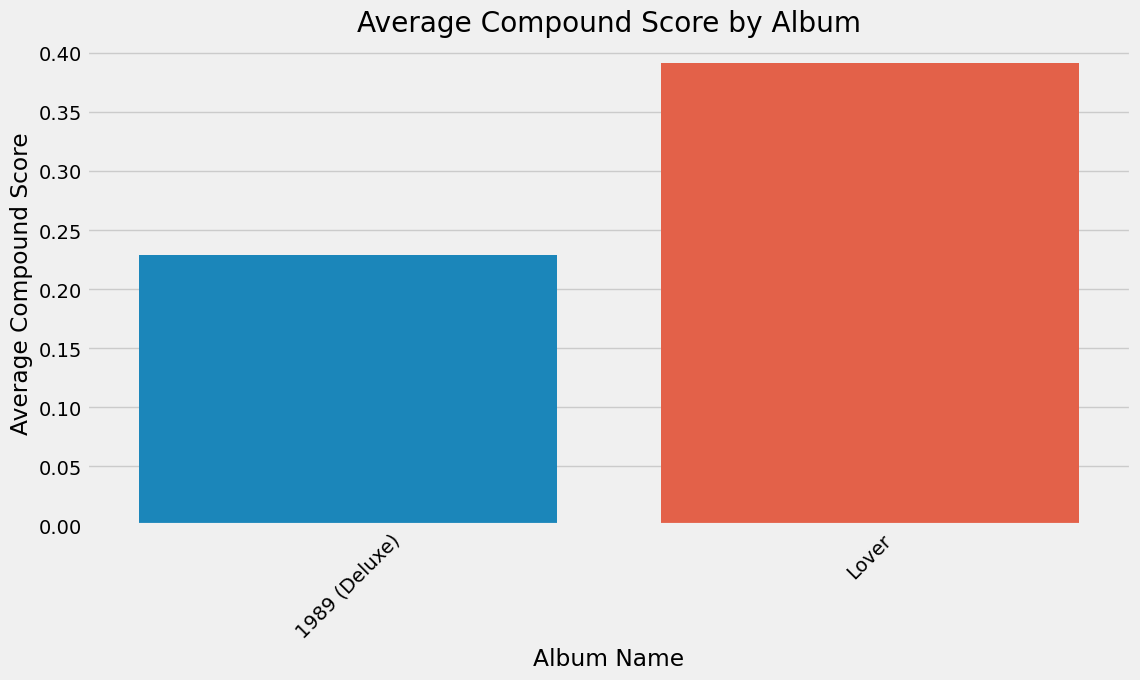

In [48]:
# Grouping by album name and calculating mean sentiment scores and sentiment counts
album_sentiment_analysis = merged_df.groupby('album_name_x').agg(
    avg_compound=('compound', 'mean'),  # Average compound score
    sentiment_count=('sentiment_category', lambda x: x.value_counts().to_dict())  # Count of sentiment categories
).reset_index()

# Displaying the result
print(album_sentiment_analysis)

# Visualizing the average compound score for each album
plt.figure(figsize=(12, 6))
sns.barplot(x='album_name_x', y='avg_compound', data=album_sentiment_analysis)
plt.title('Average Compound Score by Album')
plt.xlabel('Album Name')
plt.ylabel('Average Compound Score')
plt.xticks(rotation=45)
plt.show()


In [49]:
# Get topic frequency information from BERTopic
freq = topic_model.get_topic_info()

# Convert to a DataFrame
df_freq = pd.DataFrame(freq)


In [50]:
df_freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9,-1_yet_clear_weve_need,"[yet, clear, weve, need, right, still, wan, wa...",[moon high like friend night first met went ho...
1,0,7,0_shake_would_thats_stay,"[shake, would, thats, stay, hate, girl, hey, f...",[car window pas street memory start say past d...
2,1,5,1_place_found_gone_came,"[place, found, gone, came, lost, forever, love...",[clear blue water high tide came brought could...
3,2,2,2_silence_way home_way_wildest dream,"[silence, way home, way, wildest dream, wildes...",[said `` let get town drive city away crowd ''...
4,3,2,3_cut_never_time cause_enough,"[cut, never, time cause, enough, come, got, ta...",[saying goodbye death thousand cut flashback w...
5,4,4,4_york_new york_new_street,"[york, new york, new, street, never, walk, boy...",[go driving scooter uh know round london id lo...
6,5,3,5_yeah_tell_summer_baby,"[yeah, tell, summer, baby, every, cruel, come,...",[bored tired everything wait train coming show...
7,6,2,6_man_id_win_sick,"[man, id, win, sick, okay, coming, fight, whol...",[know adore im crazier lost film scene waving ...


In [51]:
# Merge the topic frequency DataFrame with the topic sentiment DataFrame
df_new = pd.merge(df_freq, topic_sentiment_analysis, how='inner', on='Topic')


In [52]:
topic_sentiment_analysis

,Topic,avg_compound,sentiment_count
0,-1,0.513456,"{'positive': 7, 'negative': 2}"
1,0,0.049757,"{'positive': 4, 'negative': 3}"
2,1,0.281020,"{'positive': 3, 'negative': 2}"
3,2,0.982100,{'positive': 2}
4,3,0.061150,"{'positive': 1, 'negative': 1}"
5,4,0.981450,{'positive': 4}
6,5,0.098967,"{'positive': 2, 'negative': 1}"
7,6,-0.984400,{'negative': 2}


In [53]:
# Preview the first few rows of the merged DataFrame
df_new.head()


,Topic,Count,Name,Representation,Representative_Docs,avg_compound,sentiment_count
0,-1,9,-1_yet_clear_weve_need,"[yet, clear, weve, need, right, still, wan, wa...",[moon high like friend night first met went ho...,0.513456,"{'positive': 7, 'negative': 2}"
1,0,7,0_shake_would_thats_stay,"[shake, would, thats, stay, hate, girl, hey, f...",[car window pas street memory start say past d...,0.049757,"{'positive': 4, 'negative': 3}"
2,1,5,1_place_found_gone_came,"[place, found, gone, came, lost, forever, love...",[clear blue water high tide came brought could...,0.281020,"{'positive': 3, 'negative': 2}"
3,2,2,2_silence_way home_way_wildest dream,"[silence, way home, way, wildest dream, wildes...",[said `` let get town drive city away crowd ''...,0.982100,{'positive': 2}
4,3,2,3_cut_never_time cause_enough,"[cut, never, time cause, enough, come, got, ta...",[saying goodbye death thousand cut flashback w...,0.061150,"{'positive': 1, 'negative': 1}"


### Adding a Column for the Highest Score

In [54]:
def get_highest_sentiment_score(row):
    # Extract sentiment scores and find the highest one
    scores = row['sentiment_count'].values()
    highest_score = max(scores) if scores else None
    return highest_score

# Apply the function to each row
df_new['highest_score'] = df_new.apply(get_highest_sentiment_score, axis=1)

# Preview the DataFrame
df_new.head()


,Topic,Count,Name,Representation,Representative_Docs,avg_compound,sentiment_count,highest_score
0,-1,9,-1_yet_clear_weve_need,"[yet, clear, weve, need, right, still, wan, wa...",[moon high like friend night first met went ho...,0.513456,"{'positive': 7, 'negative': 2}",7
1,0,7,0_shake_would_thats_stay,"[shake, would, thats, stay, hate, girl, hey, f...",[car window pas street memory start say past d...,0.049757,"{'positive': 4, 'negative': 3}",4
2,1,5,1_place_found_gone_came,"[place, found, gone, came, lost, forever, love...",[clear blue water high tide came brought could...,0.281020,"{'positive': 3, 'negative': 2}",3
3,2,2,2_silence_way home_way_wildest dream,"[silence, way home, way, wildest dream, wildes...",[said `` let get town drive city away crowd ''...,0.982100,{'positive': 2},2
4,3,2,3_cut_never_time cause_enough,"[cut, never, time cause, enough, come, got, ta...",[saying goodbye death thousand cut flashback w...,0.061150,"{'positive': 1, 'negative': 1}",1


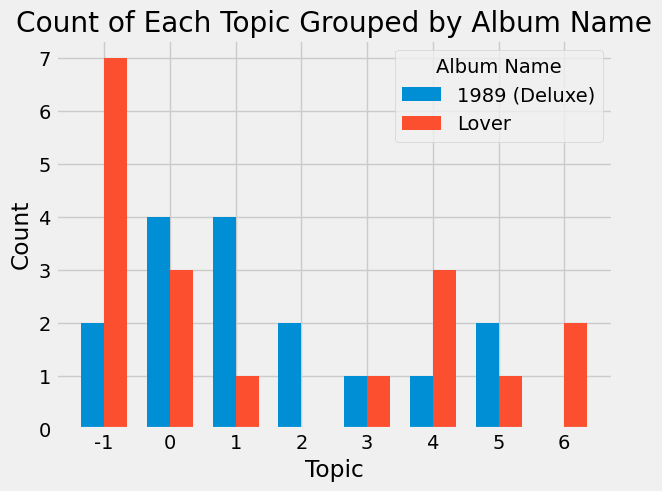

In [55]:
grouped_df = merged_df.groupby(['album_name_x', 'Topic']).size().reset_index(name='count')

# Pivot the DataFrame for easy plotting
pivot_df = grouped_df.pivot(index='Topic', columns='album_name_x', values='count').fillna(0)

# Get the topics and albums for x-axis ticks
topics = pivot_df.index
albums = pivot_df.columns

# Plot the bar chart with bars next to each other
bar_width = 0.35  # Adjust as needed
for i, album in enumerate(albums):
    plt.bar(topics + i * bar_width, pivot_df[album], width=bar_width, label=album)

plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Count of Each Topic Grouped by Album Name')
plt.xticks(topics + bar_width * (len(albums) - 1) / 2, topics)
plt.legend(title='Album Name')
plt.show()

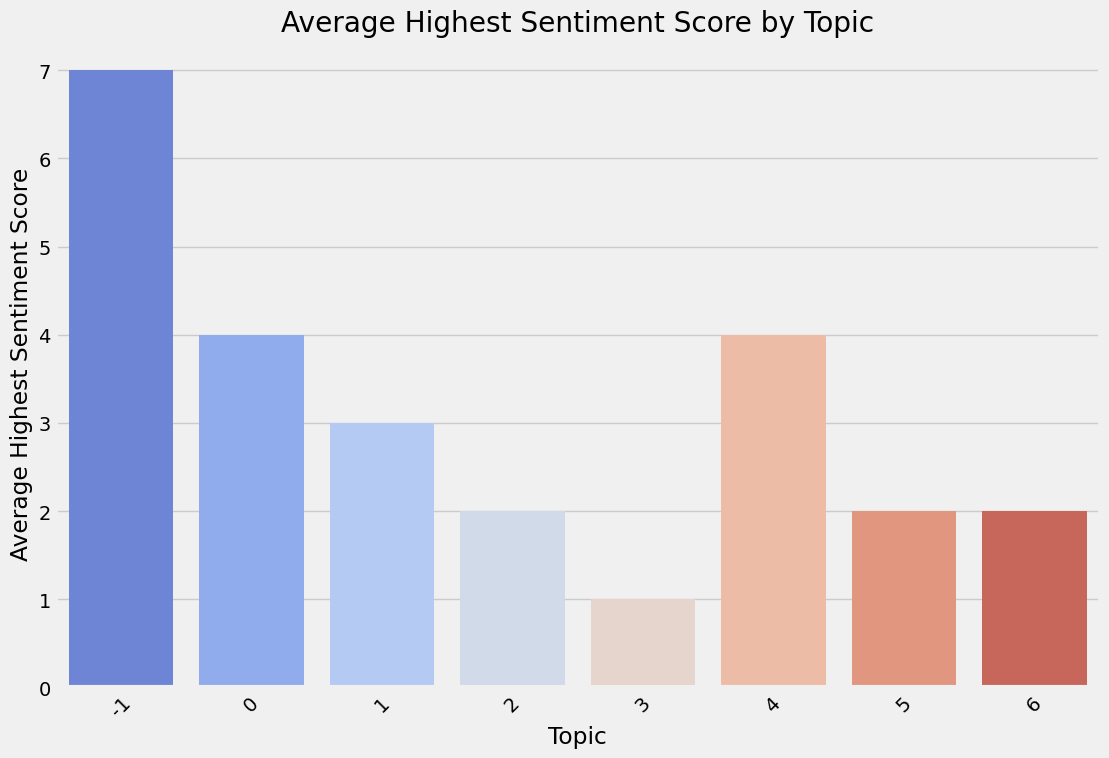

In [56]:
# Group by topic (or another category if you have one) and aggregate the highest scores
topic_score_distribution = df_new.groupby('Topic')['highest_score'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(x=topic_score_distribution.index, y=topic_score_distribution.values, palette='coolwarm')
plt.title('Average Highest Sentiment Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Highest Sentiment Score')
plt.xticks(rotation=45)
plt.show()

In [57]:
# Group by topic and calculate the sentiment distribution
topic_sentiment_corr = merged_df.groupby('Topic')['sentiment_category'].value_counts(normalize=True).unstack(fill_value=0)

# Converting the DataFrame to a format suitable for Plotly
df_for_plotly = topic_sentiment_corr.reset_index().melt(id_vars='Topic', var_name='Sentiment', value_name='Percentage')

# Creating an interactive bar chart
fig = px.bar(df_for_plotly, x='Topic', y='Percentage', color='Sentiment', barmode='group')
fig.update_layout(title='Interactive Sentiment Distribution Across Topics',
                  xaxis_title='Topic',
                  yaxis_title='Percentage of Sentiments',
                  legend_title='Sentiment')
fig.show()

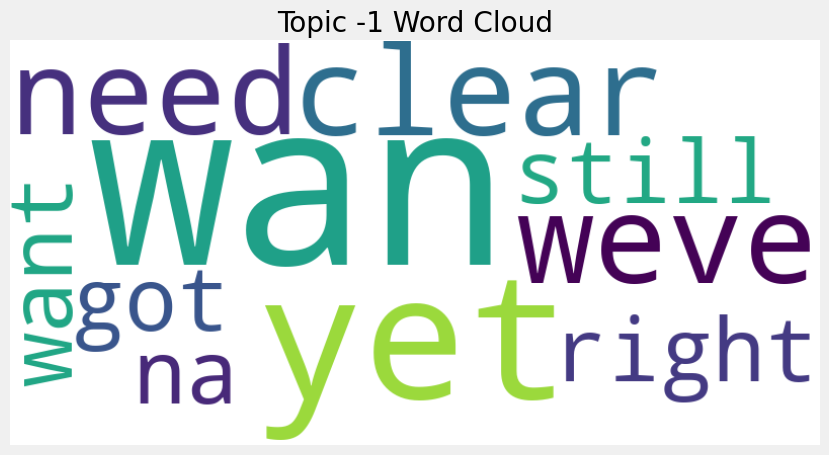

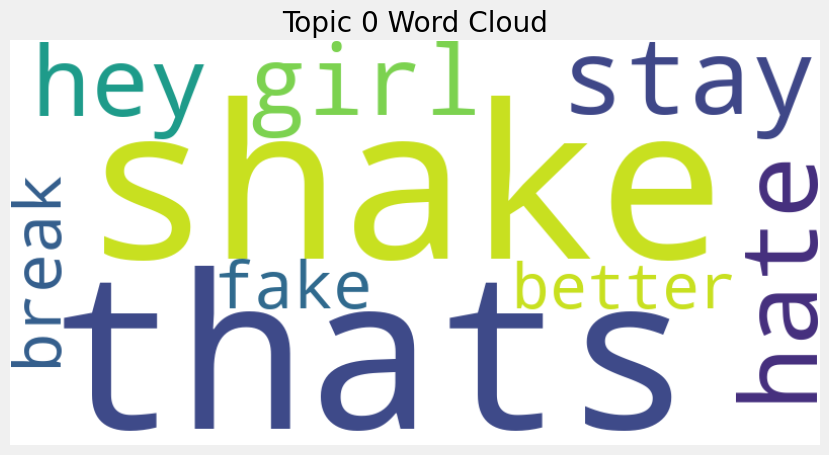

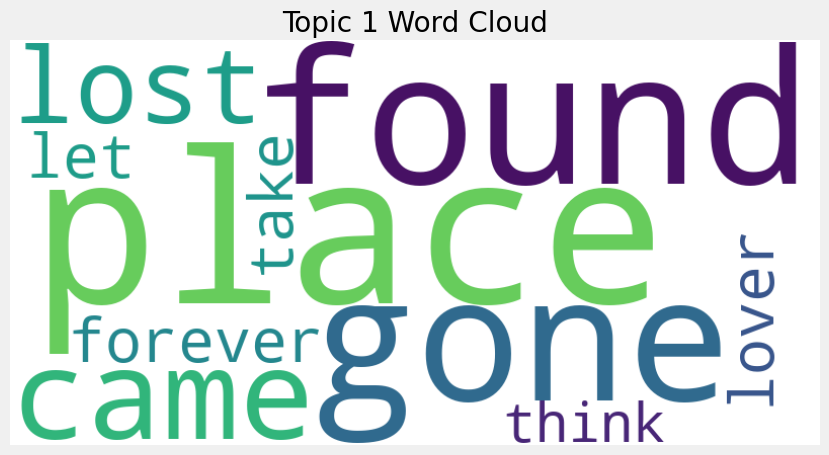

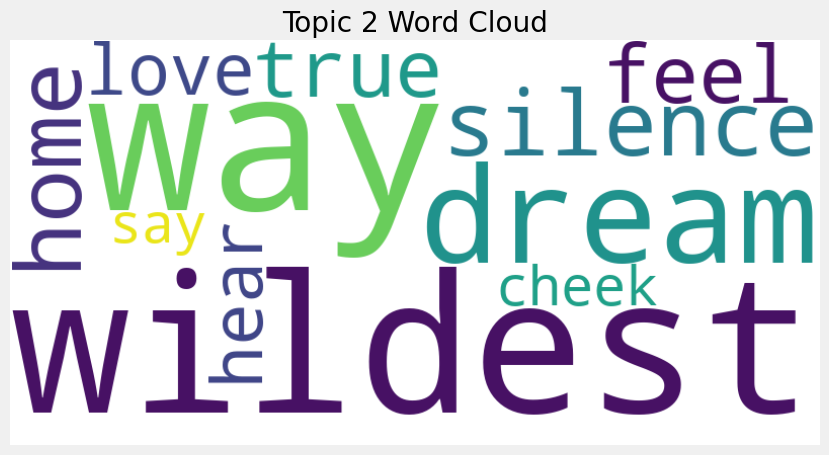

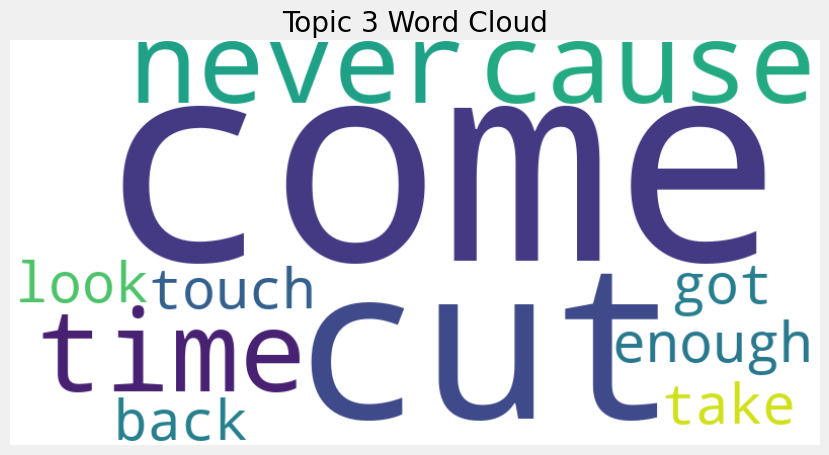

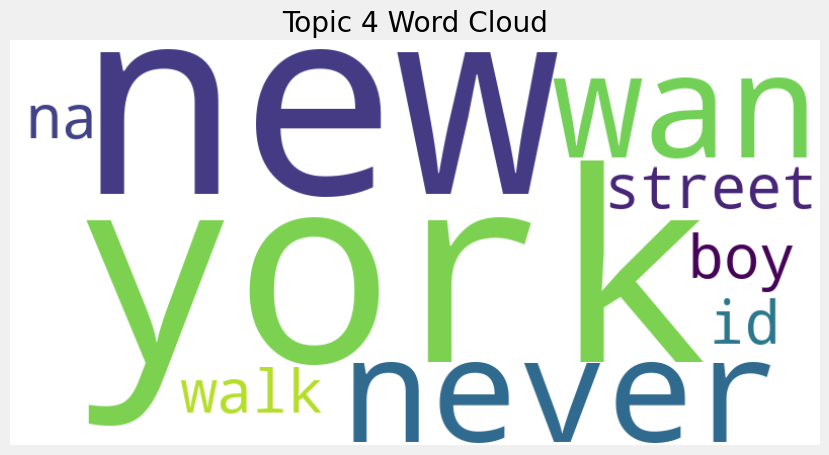

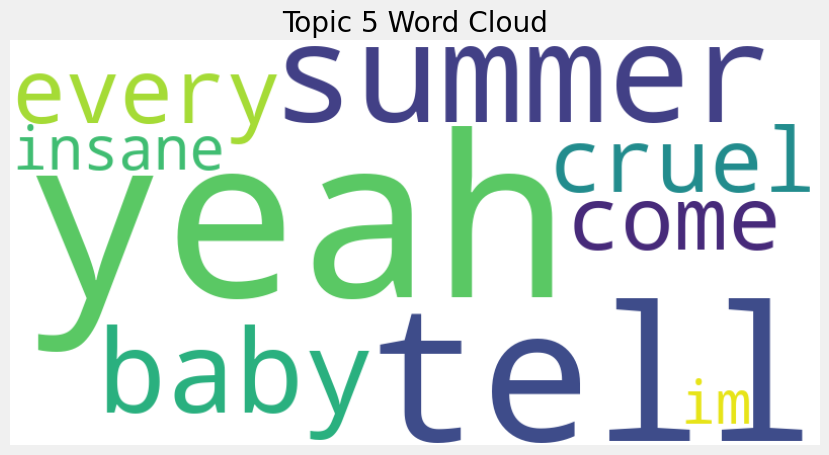

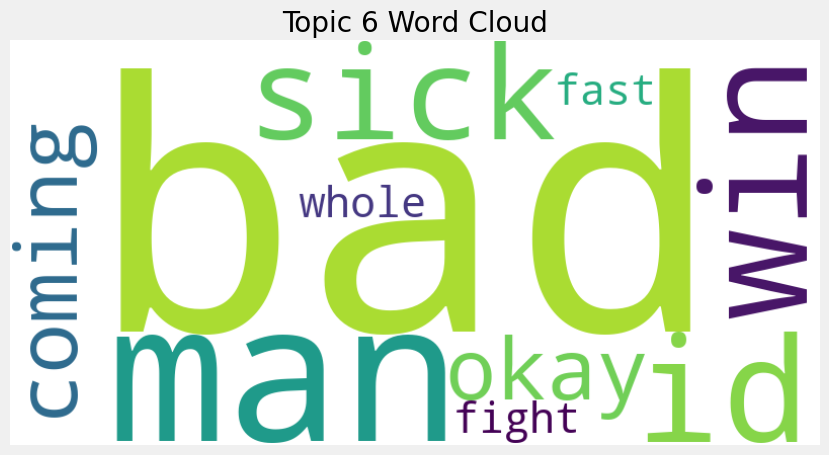

In [58]:
# Loop through each topic and generate a word cloud
for topic in df_new['Topic'].unique():
    # Extracting words for the current topic
    words = df_new[df_new['Topic'] == topic]['Representation'].iloc[0]
    
    # Generating the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

    # Plotting the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # Hide the axes
    plt.title(f"Topic {topic} Word Cloud")
    plt.show()